# Data Visualization EDA

## *Overview*
Public and non-profit enitities are eligible to receive Health Center Program grant funding to provide medical, dental, and mental health services to underserved individuals across the United States and its territories. Entities that receive this funding are charged with increasing access to quality health care services to medically underserved populations. 

In this notebook, I will visually explore the relationships between various features of each entity and whether they are correlated with the total health center funding an entity receives. 

[Link to Data Definitions](https://bphc.hrsa.gov/sites/default/files/bphc/data-reporting/2022-uds-manual.pdf)

In [388]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [389]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH

In [390]:
import warnings
warnings.filterwarnings('ignore')

## Update on 7/11/24 
I am using a new version of my dataset that does not include imputations for health center ops and finance columns. See notes at the end of the data wrangling notebook for more information.

In [391]:
health_centers = pd.read_csv(DATA_PATH + 'eda/clean_data.csv')

In [392]:
health_centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 82 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   BHCMISID                            1342 non-null   object 
 1   GrantNumber                         1342 non-null   object 
 2   HealthCenterName                    1342 non-null   object 
 3   HealthCenterCity                    1342 non-null   object 
 4   HealthCenterState                   1342 non-null   object 
 5   FundingCHC                          1342 non-null   bool   
 6   FundingMHC                          1342 non-null   bool   
 7   FundingHO                           1342 non-null   bool   
 8   FundingPH                           1342 non-null   bool   
 9   UrbanRuralFlag                      1342 non-null   object 
 10  mhc_amount                          1342 non-null   int64  
 11  chc_amount                          1342 no

The clean dataset has 84 columns and 1344 observations. Several columns from the oepartions and finance table contain missing values that are missing not at random.

In [393]:
health_centers.columns

Index(['BHCMISID', 'GrantNumber', 'HealthCenterName', 'HealthCenterCity',
       'HealthCenterState', 'FundingCHC', 'FundingMHC', 'FundingHO',
       'FundingPH', 'UrbanRuralFlag', 'mhc_amount', 'chc_amount', 'ho_amount',
       'ph_amount', 'total_hc_funding', 'bphc_total',
       'total_other_federal_grants', 'total_state_grants',
       'total_local_gov_grants', 'total_private_grants', 'total_other_revenue',
       'total_revenue', 'total_male', 'total_female', 'asian',
       'native_hawaiian', 'pac_isl', 'black', 'am_ind', 'white', 'unreported',
       'hispanic_any_race', 'total_patients', 'lep_patients', 'fpl_100_below',
       'fpl_101_to_150', 'fpl_151_to_200', 'uninsured_0_17', 'uninsured_18_up',
       'medicaid_0_17', 'medicaid_18_up', 'medicare_18_up',
       'public_insurance_0_17', 'public_insurance_18_up',
       'private_insurance_0_17', 'private_insurance_18_up', 'total_0_17',
       'total_18_up', 'migrant_patients', 'homeless_patients',
       'school_based_patients

In [394]:
health_centers.head(3)

BHCMISID GrantNumber                          HealthCenterName  \
0   010030  H80CS00803               HOLYOKE HEALTH CENTER, INC.   
1   010040  H80CS00443          MAINE MOBILE HEALTH PROGRAM INC.   
2   010060  H80CS00741  FAIR HAVEN COMMUNITY HEALTH CLINIC, INC.   

  HealthCenterCity HealthCenterState  FundingCHC  FundingMHC  FundingHO  \
0          Holyoke                MA        True       False      False   
1          Augusta                ME       False        True      False   
2        New Haven                CT        True       False      False   

   FundingPH UrbanRuralFlag  mhc_amount  chc_amount  ho_amount  ph_amount  \
0      False          Urban           0     5721128          0          0   
1      False          Rural     1758567           0          0          0   
2      False          Urban           0     4569124          0          0   

   total_hc_funding  bphc_total  total_other_federal_grants  \
0           5721128     7584461                      568943   
1           1758567     2258650                           0   
2           4569124     6571573                       44836   

   total_state_grants  total_local_gov_grants  total_private_grants  \
0             2915656                       0                764680   
1                   0                       0                 25000   
2              511690                  258065               1189046   

   total_other_revenue  total_revenue  total_male  total_female  asian  \
0             14258919       28330029        8821         10323    148   
1                36578        2320228         609           241      0   
2               270649        9064640       14150         17768    810   

   native_hawaiian  pac_isl  black  am_ind  white  unreported  \
0               17        2    432      47   3035        2228   
1                0        7    332      12     12          22   
2                6       23   7036      34   2601         729   

   hispanic_any_race  total_patients  lep_patients  fpl_100_below  \
0              12631           19144          8371           2706   
1                471             850           654            768   
2              19204           31918         12686          13138   

   fpl_101_to_150  fpl_151_to_200  uninsured_0_17  uninsured_18_up  \
0             184             103             104              609   
1              68              11              35              734   
2            3958            1685            1329             3138   

   medicaid_0_17  medicaid_18_up  medicare_18_up  public_insurance_0_17  \
0           4882            8638            3320                     10   
1             24              36               4                      0   
2          16495            5818            1686                      0   

   public_insurance_18_up  private_insurance_0_17  private_insurance_18_up  \
0                      13                     166                     1410   
1                       0                       8                       13   
2                       0                    1543                     1908   

   total_0_17  total_18_up  migrant_patients  homeless_patients  \
0        5157        13987                45               2998   
1          64          786               769                  5   
2       19368        12550                 5                208   

   school_based_patients  veteran_patients  public_housing_patients  \
0                      0               332                    19144   
1                      0                 9                        0   
2                   1937                24                    29342   

   total_costs_medical  total_costs_dental  total_costs_mh  \
0                  NaN                 NaN             NaN   
1             774931.0             26613.0        313483.0   
2           21619441.0           1391991.0       3879153.0   

   total_costs_enabling  total_costs_quality  to

## Health Center Funding and Patients Served

I first want to take a look at the distribution of health center funding, total patients served, and any correlation between these variables across entities. I also want to see if there are any particular clusters around funding and whether an entity is considered a rural or urban provider. 

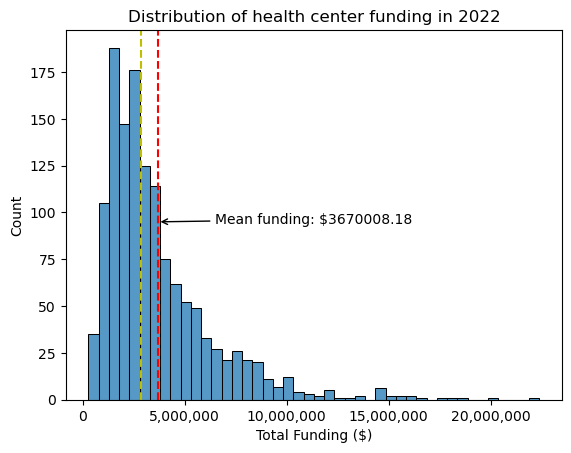

In [395]:
# plot ahealth center funding histogram
fig, ax = plt.subplots()
sns.histplot(x='total_hc_funding', data=health_centers)
plt.title('Distribution of health center funding in 2022')
plt.xlabel('Total Funding ($)')

mean_funding = health_centers['total_hc_funding'].mean()
plt.axvline(mean_funding, linestyle='--', color='r', label=f'Mean funding: ${mean_funding:.2f}')

# Adding text and arrow annotation
plt.annotate('Mean funding: ${:.2f}'.format(mean_funding),
             xy=(mean_funding, 95),
             xycoords='data',
             xytext=(6500000, 100),
             textcoords='data',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black'),
             horizontalalignment='left',
             verticalalignment='top')

plt.axvline(health_centers['total_hc_funding'].median(), linestyle='--', color='y', label=f'Median funding: ${mean_funding:.2f}')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 


In [396]:
health_centers[['total_hc_funding']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

total_hc_funding
count          1342.00
mean        3670008.18
std         2741921.46
min          275778.00
25%         1804645.00
50%         2858228.50
75%         4605680.25
max        22382349.00

Health center funding is heavily right skewed. Most health centers between 1.8M and 4.6M of health center funding annually, with the mean funding level just over 3.6 million. 

There are several outliers that get more than 10,000,000 and some as high as 22,000,000 in total health center funding each year. 

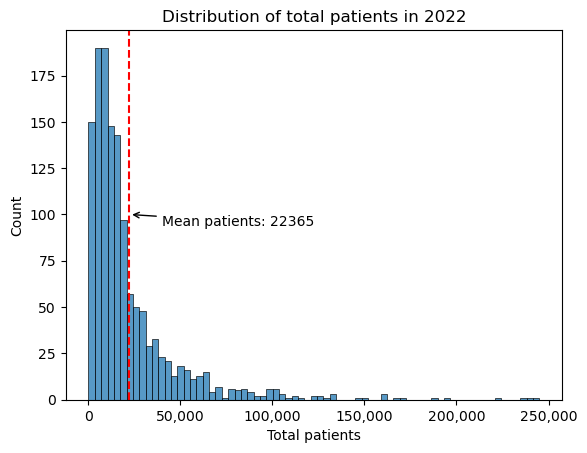

In [397]:
# plot distribution of patients served
fig, ax = plt.subplots()
sns.histplot(x='total_patients', data=health_centers)
plt.title('Distribution of total patients in 2022')
plt.xlabel('Total patients')

mean_patients = health_centers['total_patients'].mean()
plt.axvline(mean_patients, linestyle='--', color='r', label=f'Mean patients served: {mean_patients:.0f}')

# Adding text and arrow annotation
plt.annotate('Mean patients: {:.0f}'.format(mean_patients),
             xy=(mean_patients, 100),
             xycoords='data',
             xytext=(40000, 100),
             textcoords='data',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black'),
             horizontalalignment='left',
             verticalalignment='top')


ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

The total patients served is also heavily skewed to the right. Most health centers serve less than 20,000 patients per year with the mean being just over 22,000 patients per year. 

There are many outliers for this feature as well, with some as high as 100,000 patients per year and the max being just under 250,000 per year. 

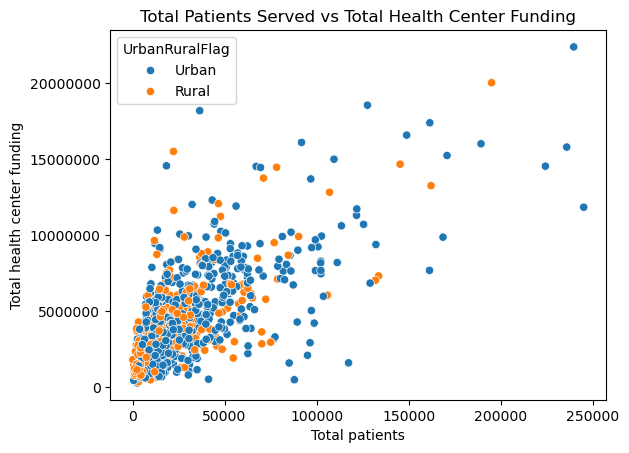

In [398]:
# scatter plot of health center funding vs total patients served
fix, ax = plt.subplots()

sns.scatterplot(x='total_patients', y='total_hc_funding', data=health_centers, hue='UrbanRuralFlag')
plt.title('Total Patients Served vs Total Health Center Funding')
plt.xlabel('Total patients')
plt.ylabel('Total health center funding')
ax.ticklabel_format(style='plain', axis='both')

There is definitely a strong, positive correlation between funding received and patients served, however there are alo many outliers.  

There isn't an immediate relationship between urban vs rural health centers and funding. It is suprising to see that there are a few rural providers that serve significantly more patients than some urban providers. Additionally, we can see the outliers as far as those who serve an average number of patients but receive nearly twice as much funding as entities serving the same number of patients. I'll want to investigate this further with other features like other funding sources, social determinants of health in their patient populations, high need, and operational details. 

**Do urban providers receive more funding than rural providers after controlling for total number of patients served?**

I will conduct an ANCOVA statistical test. This type of statistical test will allow me to isolate the effect of the categorical variable (Urban or Rural) on the dependent variable (total health center funding). I want to control for patient volume because the total number of patients is highly correlated with the total health center funding. 

In [399]:
model = ols('total_hc_funding ~ total_patients + C(UrbanRuralFlag)', data=health_centers).fit()
ancova_table = sm.stats.anova_lm(model, typ=2)
ancova_table

sum_sq      df            F         PR(>F)
C(UrbanRuralFlag)  9.050661e+12     1.0     2.579500   1.084916e-01
total_patients     5.167824e+15     1.0  1472.865281  5.706408e-218
Residual           4.698133e+15  1339.0          NaN            NaN

The p-value associated with the `UrbanRuralFlag` feature (p> 0.107) is not statistically significant and therefore we can reject the null hypothesis. After controlling for patient counts, there is not a statistically significant difference in the total health center funding Urban providers receive compared to Rural providers. 

The p-value for `total_patients` is extremely low (nearly zero), indicating that patient volume is a significant determinator of total health center funding.

**Top Funded Health Centers vs Top Numbers of Patients Served**

I want to take a look at the 10 health centers that receive the most funding. I want to compare this list to the top 10 health centers by patients served. 

In [400]:
top_funded = health_centers[['BHCMISID', 'HealthCenterName', 'HealthCenterCity', 'HealthCenterState','total_hc_funding', 'total_patients']]\
                    .sort_values('total_hc_funding', ascending=False).head(10)

top_funded['rank'] = range(1, len(top_funded) + 1)

In [401]:
top_patients = health_centers[['BHCMISID', 'HealthCenterName', 'HealthCenterCity', 'HealthCenterState', 'total_hc_funding', 'total_patients']]\
                    .sort_values('total_patients', ascending=False).head(10)

top_patients['rank'] = range(1, len(top_patients) + 1)

In [402]:
# top funded states
top_funded['HealthCenterState'].value_counts()

HealthCenterState
CA    3
NY    2
WA    1
MN    1
IL    1
CO    1
AL    1
Name: count, dtype: int64

In [403]:
# states with most patients served
top_patients['HealthCenterState'].value_counts()

HealthCenterState
CA    4
WA    2
NY    1
CO    1
IL    1
FL    1
Name: count, dtype: int64

It is interesting that states that have the most funding across entities in the top 10 are not necessarily the states that serve the most patients. We see that Alabama is one of the states with the most funding due to one organization, but is not in the top 10 for patients served. I want to take a look at these organizations more closely.

In [404]:
top_funded_vs_patients = top_funded.merge(top_patients, on='rank', suffixes=('_F', '_P'))
top_funded_vs_patients[['rank', 'HealthCenterName_F', 'HealthCenterName_P']]

rank                                 HealthCenterName_F  \
0     1                     HUDSON RIVER HEALTH CARE, INC.   
1     2                   YAKIMA VALLEY FARMWORKERS CLINIC   
2     3                               CLINICA SIERRA VISTA   
3     4  WEST SIDE COMMUNITY HEALTH SERVICES, INC. DBA ...   
4     5           FAMILY HEALTH CENTERS OF SAN DIEGO, INC.   
5     6                    SUNSET PARK HEALTH COUNCIL, INC   
6     7                                    SIHF HEALTHCARE   
7     8                 DENVER HEALTH & HOSPITAL AUTHORITY   
8     9                          FAMILY HEALTHCARE NETWORK   
9    10              QUALITY OF LIFE HEALTH SERVICES, INC.   

                              HealthCenterName_P  
0           ALTA MED HEALTH SERVICES CORPORATION  
1                 HUDSON RIVER HEALTH CARE, INC.  
2                      FAMILY HEALTHCARE NETWORK  
3                SEA-MAR COMMUNITY HEALTH CENTER  
4               YAKIMA VALLEY FARMWORKERS CLINIC  
5             DENVER HEALTH & HOSPITAL AUTHORITY  
6                ACCESS COMMUNITY HEALTH NETWORK  
7                               MCR HEALTH, INC.  
8  UNITED HLTH CNTRS OF SAN JOAQUIN VALLEY, INC.  
9       FAMILY HEALTH CENTERS OF SAN DIEGO, INC.

In [405]:
# calculate differences in funding and patients served between top funded and top patients
top_funded_vs_patients['funding_difference'] = top_funded_vs_patients['total_hc_funding_F'] - top_funded_vs_patients['total_hc_funding_P']
top_funded_vs_patients['patient_difference'] = top_funded_vs_patients['total_patients_F'] - top_funded_vs_patients['total_patients_P']
top_funded_vs_patients[['HealthCenterName_F', 'HealthCenterName_P', 'rank', 'funding_difference', 'patient_difference']]

HealthCenterName_F  \
0                     HUDSON RIVER HEALTH CARE, INC.   
1                   YAKIMA VALLEY FARMWORKERS CLINIC   
2                               CLINICA SIERRA VISTA   
3  WEST SIDE COMMUNITY HEALTH SERVICES, INC. DBA ...   
4           FAMILY HEALTH CENTERS OF SAN DIEGO, INC.   
5                    SUNSET PARK HEALTH COUNCIL, INC   
6                                    SIHF HEALTHCARE   
7                 DENVER HEALTH & HOSPITAL AUTHORITY   
8                          FAMILY HEALTHCARE NETWORK   
9              QUALITY OF LIFE HEALTH SERVICES, INC.   

                              HealthCenterName_P  rank  funding_difference  \
0           ALTA MED HEALTH SERVICES CORPORATION     1            10545167   
1                 HUDSON RIVER HEALTH CARE, INC.     2            -2355213   
2                      FAMILY HEALTHCARE NETWORK     3             2757398   
3                SEA-MAR COMMUNITY HEALTH CENTER     4             3649396   
4               YAKIMA VALLEY FARMWORKERS CLINIC     5            -2635820   
5             DENVER HEALTH & HOSPITAL AUTHORITY     6              569253   
6                ACCESS COMMUNITY HEALTH NETWORK     7              858362   
7                               MCR HEALTH, INC.     8             6143340   
8  UNITED HLTH CNTRS OF SAN JOAQUIN VALLEY, INC.     9             2538602   
9       FAMILY HEALTH CENTERS OF SAN DIEGO, INC.    10            -1883576   

   patient_difference  
0               -5438  
1              -44627  
2             -108224  
3             -187700  
4              -33511  
5              -40352  
6              -79031  
7               20640  
8               73702  
9             -139224

Although there is some overlap, health centers that serve more patients don't necessarily receive more health center grant funding. For example, Alta Med Health Services Corporation is the top patient serving health center and serves 5,438 more patients a year than the Hudson River Health Care, Inc, the entity that receives the most health center funding. Hudson River receives 10.5 million more per year than Alta Med. Additionally, Alta Med is actually not even in the top 10 funded health centers, despite serving the most patients. Similarly, Sea-Mar Community Health Center is the fourth largest health center in terms of patients served and is not in the top 10 most funded health centers. 

In [406]:
# count urban and rural providers
urb_rur = health_centers['UrbanRuralFlag'].value_counts().reset_index()
urb_rur['perc'] = round(urb_rur['count'] / urb_rur['count'].sum() * 100, 2)
urb_rur

UrbanRuralFlag  count   perc
0          Urban    794  59.17
1          Rural    548  40.83

In [407]:
funding_grouping = health_centers.groupby('UrbanRuralFlag')['total_hc_funding'].sum().reset_index()
funding_grouping['perc_of_total_funding'] = round((funding_grouping['total_hc_funding'] / funding_grouping['total_hc_funding'].sum()) * 100, 2)
funding_grouping

UrbanRuralFlag  total_hc_funding  perc_of_total_funding
0          Rural        1746613110                  35.46
1          Urban        3178537861                  64.54

Most entities are urban providers, however, there is still a significant number of rural providers. Although urban providers only represent 58.7% of the total number of entities, they receive 64.1% of the total available health center funding. Rural providers represent 41.3% of the total number of providers and receive 35.9% of the funding. 

## Funding Streams 

Below is an analyis of non-patient revenue streams, including grant funding (federal, state, local government, private funders) and other revenue.

In [408]:
health_centers[['total_hc_funding',
       'bphc_total', 'total_other_federal_grants', 'total_state_grants', 'total_local_gov_grants',
       'total_private_grants', 'total_other_revenue', 'total_revenue']].describe().apply(lambda x: x.apply('{0:.2f}'.format)).T

count         mean          std        min  \
total_hc_funding            1342.00   3670008.18   2741921.46  275778.00   
bphc_total                  1342.00   6091361.02   5111848.21  358149.00   
total_other_federal_grants  1342.00    443155.04   1287256.30       0.00   
total_state_grants          1342.00    776066.03   1624622.92       0.00   
total_local_gov_grants      1342.00    664370.36   2404550.80       0.00   
total_private_grants        1342.00    802644.00   1631130.94       0.00   
total_other_revenue         1342.00   1103317.92  11790247.49       0.00   
total_revenue               1342.00  10572330.44  17186491.82  828062.00   

                                   25%         50%          75%           max  
total_hc_funding            1804645.00  2858228.50   4605680.25   22382349.00  
bphc_total                  2972587.00  4554745.50   7333201.25   48065368.00  
total_other_federal_grants        0.00        0.00    247770.75   13597206.00  
total_state_grants                0.00   185016.00    771746.75   19982632.00  
total_local_gov_grants            0.00        0.00    301669.75   48056004.00  
total_private_grants          15601.50   219663.00    883261.75   22007477.00  
total_other_revenue           15112.25   137021.50    546141.25  415573508.00  
total_revenue               4132924.25  6691005.00  12428951.00  485335878.00

**Overall Distribution of Non-Patient Revenue**

Most organizations do not receive other federal grants or local government grants. Half of the health centers do receive state and 75% receive private funding as well as other revenue.

Some organizations also have significantly larger operations, as can be seen by the maximum values for total other revenue 415,573,508.00 and total revenue 485,335,878.00 compared to the medians for these measures, 134,991.50 and 6,656,907.00 respectively. It may be worth grouping entities by their opeartional sizes given revenue and patient populations. 

I'm interested to know the total health center funding as a proportion of total non-patient revenue. I also want to see the health center funding as a proportion of total grant funding.

After gathering some new summary data, I will drop the detailed breakdown of grant funding type to reduce the number of columns. I will preserve information about health center funding, other revenue, and total revenue. Before dropping columns, I will look at pairplots for these values.

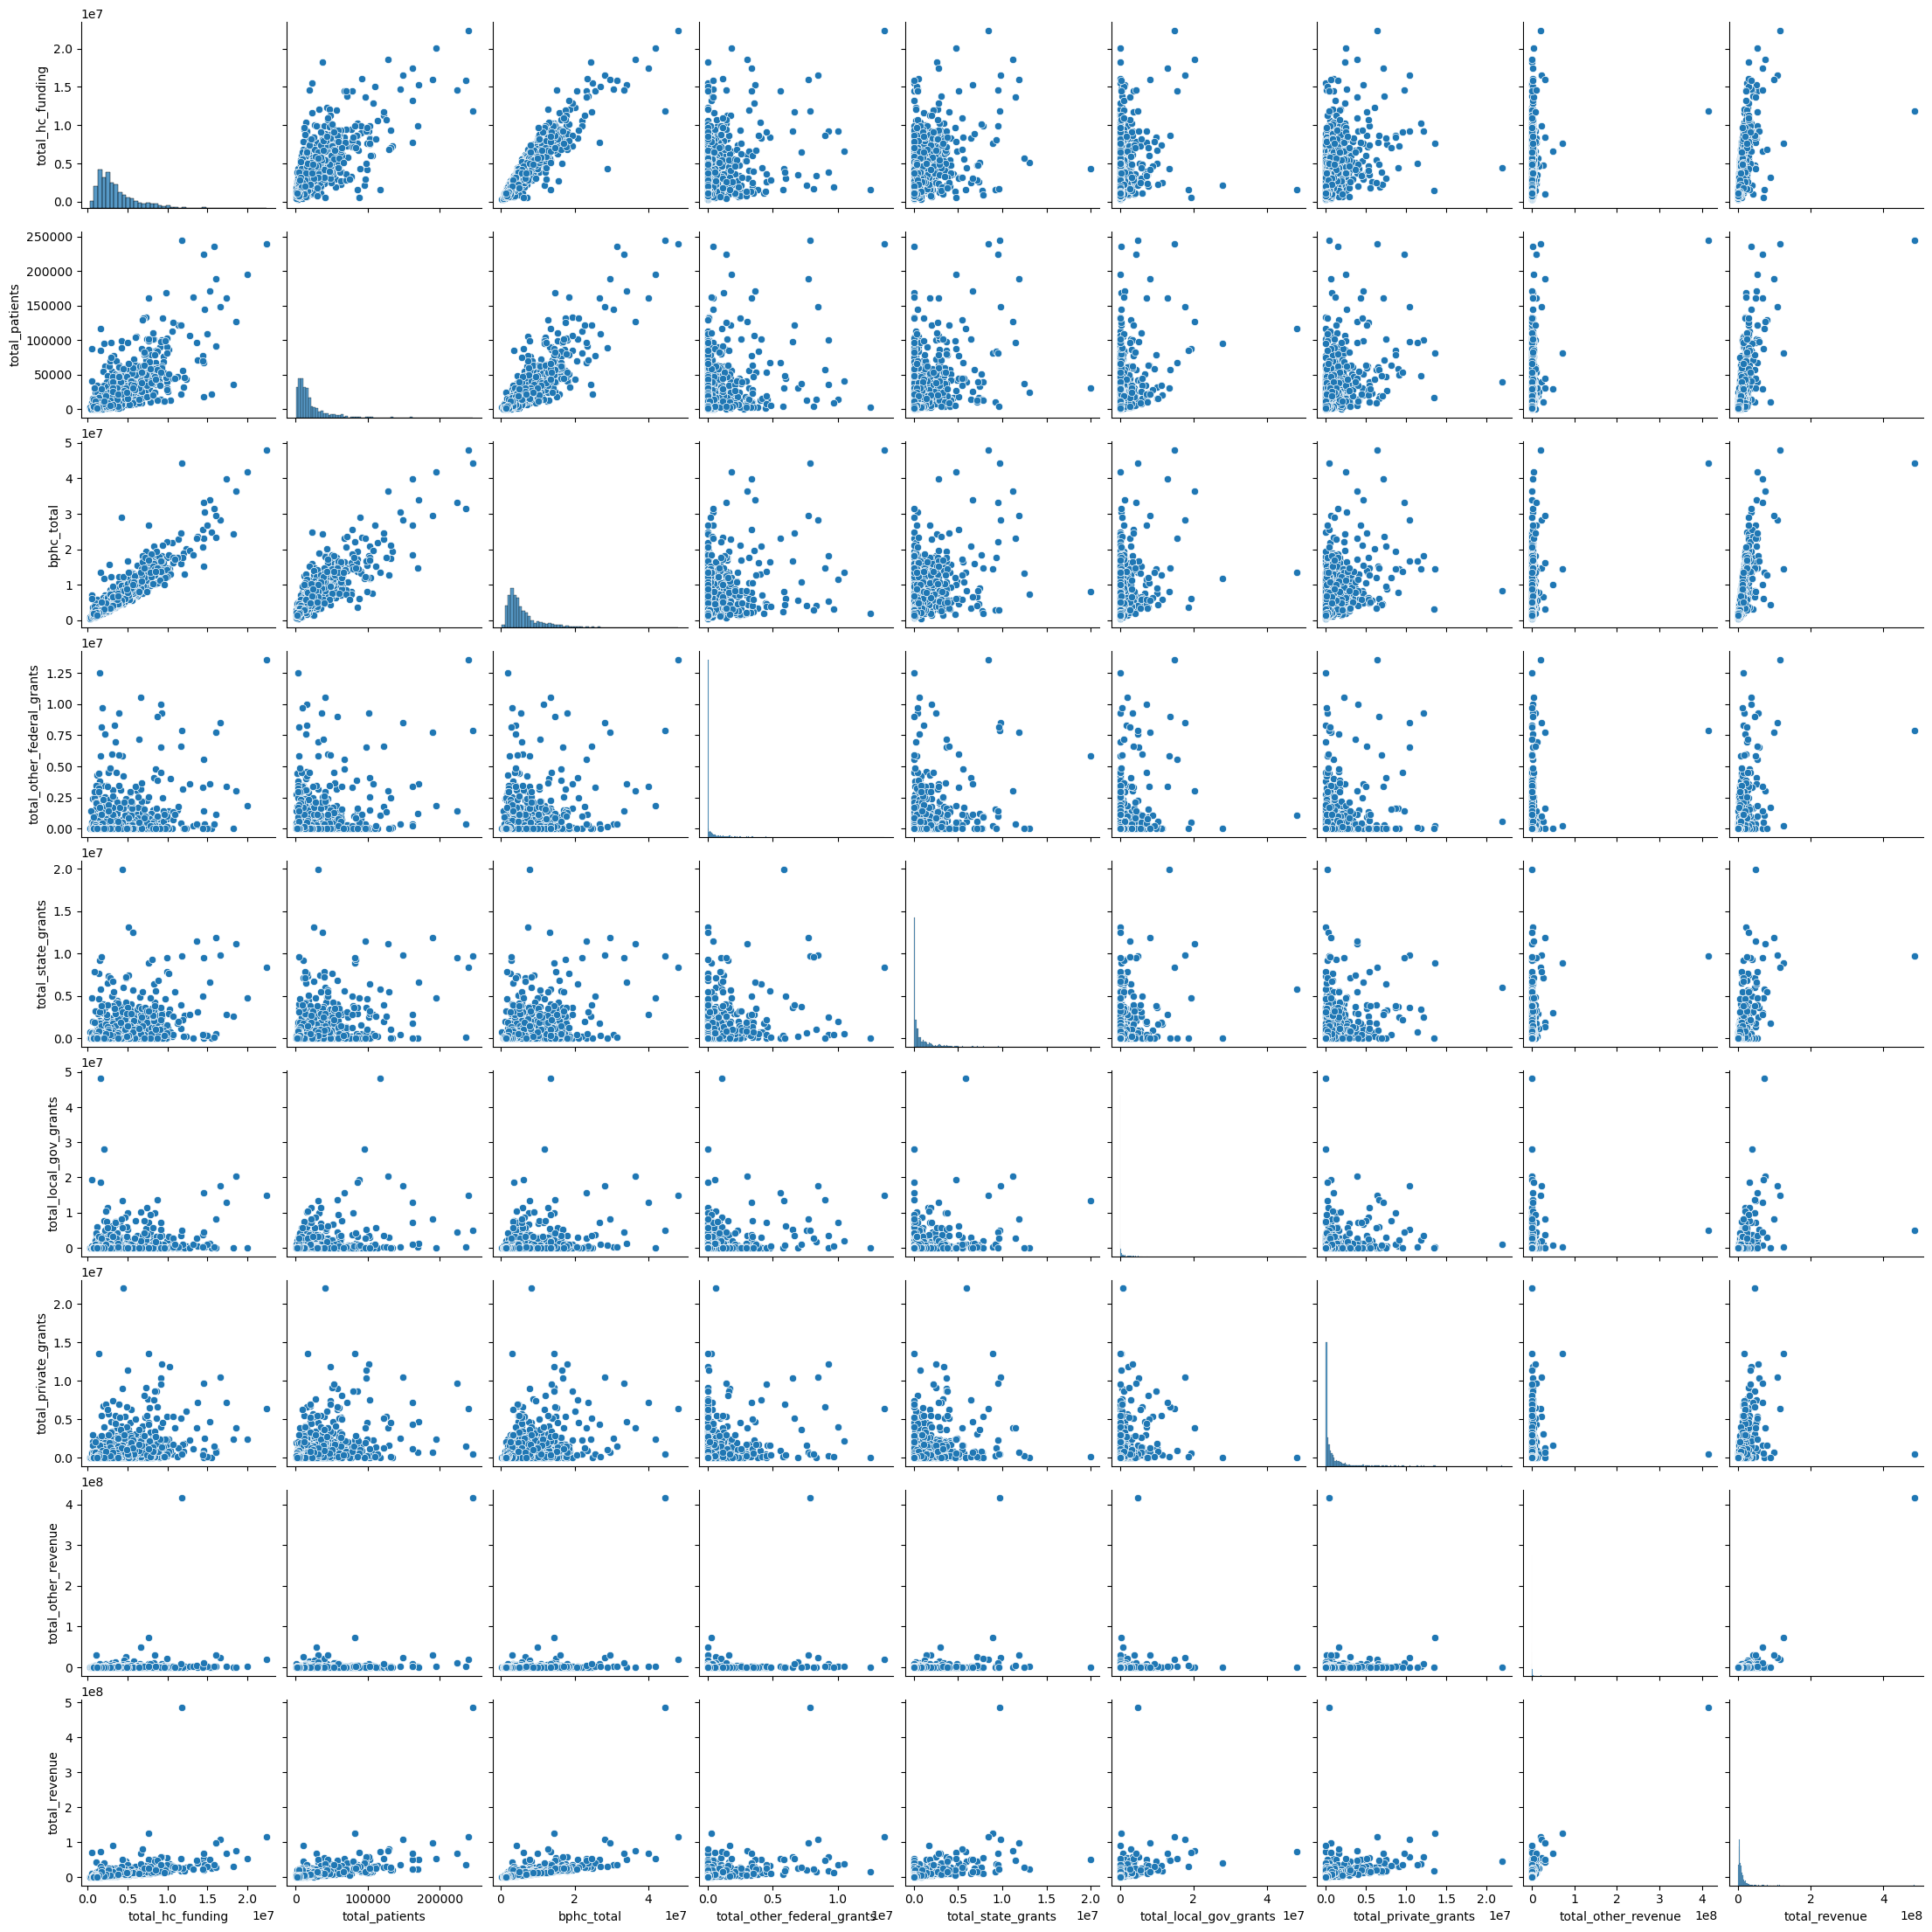

In [409]:
non_patient_funding = health_centers[['total_hc_funding', 'total_patients',
       'bphc_total', 'total_other_federal_grants', 'total_state_grants', 'total_local_gov_grants',
       'total_private_grants', 'total_other_revenue', 'total_revenue']]

sns.pairplot(non_patient_funding)

There are clearly a few outliers in terms of funding that seem to have significantly more other revenue, total revenue, and other grants compared to the vast majority of providers. 

There are some overall positive trends between total revenue and total health center funding. Additionally, there is strong correlation between health center funding and bphc funding, however this is not surprising at health center funding is a type of bphc funding organizations could have. 

I want to look at funding proportions to see the size of the role health center funding plays in these organization's operations. Does health center funding make up most of the total non-patient revenue? Are other funding streams more significant?

In [410]:
# calculate health center funding as a proportion of total revenue
health_centers['hc_grant_revenue_ratio'] = health_centers['total_hc_funding'] / health_centers['total_revenue']

health_centers['bphc_funding'] = health_centers['bphc_total'] - health_centers['total_hc_funding']

# calculate health center funding as a proportion of all grant funding
cols_to_sum = ['bphc_funding', 'total_other_federal_grants', 'total_state_grants', 'total_local_gov_grants', 'total_private_grants']
health_centers['total_grant_funding'] = health_centers[cols_to_sum].sum(axis=1)

# calculate total grant funding as a proportion of total revenue
health_centers['grants_to_rev_ratio'] = round(health_centers['total_grant_funding'] / (health_centers['total_revenue'] - health_centers['total_hc_funding']), 5)


In [411]:
# keep track of columns that need to be removed from clean dataset at the end
data_leakage_cols = []

In [412]:
# cols to remove after EDA
data_leakage_cols.extend(['bphc_total', 'total_revenue', 'hc_grant_revenue_ratio']) # contains information about the target variable total_hc_funding
data_leakage_cols

['bphc_total', 'total_revenue', 'hc_grant_revenue_ratio']

In [413]:
# display information about ratios
health_centers[['hc_grant_revenue_ratio', 'grants_to_rev_ratio', 'total_grant_funding']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

hc_grant_revenue_ratio grants_to_rev_ratio total_grant_funding
count             1342.00000          1340.00000          1342.00000
mean                 0.44924             0.84129       5107588.26453
std                  0.17993             0.18265       6662437.10927
min                  0.00689             0.04212             0.00000
25%                  0.31902             0.77060       1516442.75000
50%                  0.44752             0.90056       2946766.00000
75%                  0.57548             0.97643       6186718.00000
max                  1.00000             1.00000      68907915.00000

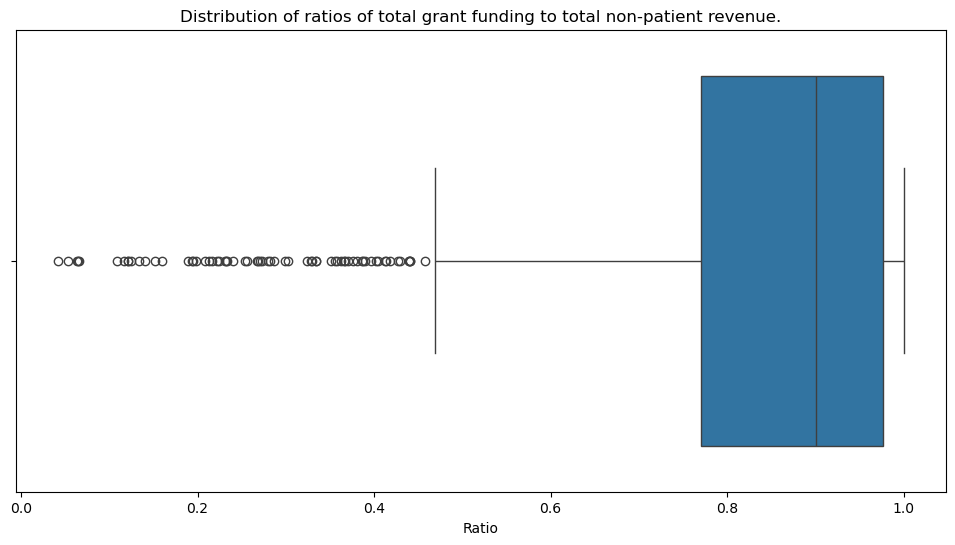

In [414]:
fig, ax = plt.subplots(figsize=(12,6))

plt.title('Distribution of ratios of total grant funding to total non-patient revenue.')
sns.boxplot(x='grants_to_rev_ratio', data=health_centers)
plt.xlabel('Ratio');

There is at least one health center that does not receive any other revenue from grant funding outside of health center funding.

The distribution of ealth center funding as a proportion of total non-patient revenue ranges from nearly 0% to 100%. The inner quartile range of hc_grant_revenue_ratio is 32% to 58%. Health center funding makes up a large portion of FQHC non-patient revenue. 

In [415]:
# identify health centers that receive no other grant funding
zero_grant_funding = health_centers[health_centers['total_grant_funding'] == 0]
print(f"Number of entries with zero total grant funding: {len(zero_grant_funding)}")
print(zero_grant_funding[['HealthCenterName', 'bphc_funding', 'total_other_federal_grants', 
                          'total_state_grants', 'total_local_gov_grants', 'total_private_grants', 
                          'total_hc_funding', 'total_revenue', 'grants_to_rev_ratio']].head())

Number of entries with zero total grant funding: 2
                                   HealthCenterName  bphc_funding  \
1063  SANTA CLARA VALLEY HEALTH AND HOSPITAL SYSTEM             0   
1204            BENEVOLENCE INDUSTRIES INCORPORATED             0   

      total_other_federal_grants  total_state_grants  total_local_gov_grants  \
1063                           0                   0                       0   
1204                           0                   0                       0   

      total_private_grants  total_hc_funding  total_revenue  \
1063                     0           2664487        2664487   
1204                     0           2393860        2393860   

      grants_to_rev_ratio  
1063                  NaN  
1204                  NaN  


Santa Clara Valley Health and Hospital System and Benevolence Industries Incorporated are the only two health care providers who don't receive any other grant funding outside of the health center funding.

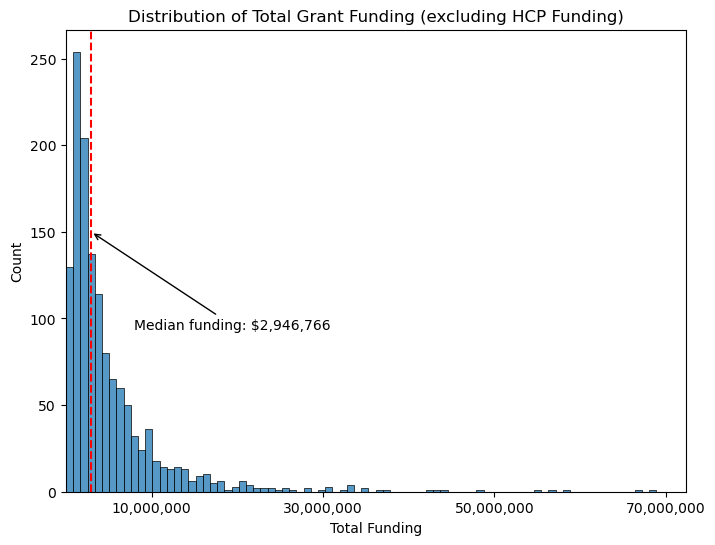

In [416]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(health_centers['total_grant_funding'])
ax.set(title='Distribution of Total Grant Funding (excluding HCP Funding)', xlabel='Total Funding')
plt.ticklabel_format(style='plain')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 


median_funding = health_centers['total_grant_funding'].median()
plt.axvline(median_funding, linestyle='--', color='r', label=f'Median funding: ${median_funding:,.0f}')

# Adding text and arrow annotation
plt.annotate('Median funding: ${:,.0f}'.format(median_funding),
             xy=(median_funding, 150),
             xycoords='data',
             xytext=(8000000, 100),
             textcoords='data',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black'),
             horizontalalignment='left',
             verticalalignment='top')

# Get current x-ticks and set every other tick, starting from the first
ticks = ax.get_xticks()
ax.set_xticks(ticks[::2])  # Select every second tick
ax.set_xlim(left=0)

plt.show()

**Total Grant Funding Analysis**

The median total grant funding health centers receive after excluding health center program (HCP) funding is just over $2.9M. 

Seventy-five percent of health centers receive less than $6.1M in total grant funding after excluding HCP funding. 

The top 23th percentile of organizations in terms of other grant funding have a huge range, starting at just over $6.1M up to nearly $70M in other grant funding. 

In [417]:
health_centers[['total_patients', 'total_grant_funding', 'total_hc_funding']].corr()

total_patients  total_grant_funding  total_hc_funding
total_patients             1.000000             0.750747          0.730138
total_grant_funding        0.750747             1.000000          0.613714
total_hc_funding           0.730138             0.613714          1.000000

Larger health systems likely receive large grants because they have the opeartional capacity to manage funding at these levels. Total grant funding is highly correlated with total number of patients served (coef of 0.75). Some of these entities likely receive grant funding for programs/services and research funding.

I won't need the individual grant type columns for further analysis or modeling as these would be redundant. I'll drop them below.

In [418]:
# drop detailed grant type columns type and keep the total_grant_funding column
health_centers.drop(columns=cols_to_sum, inplace=True)

**Other Revenue Analysis**

Other revenue includes revenue that is unrelated to charge- based services or to grants. This includes things like fundraising, interest revenue, rent from tenants, patient health records fees, individual monetary donations, receipts from vending machines, retail pharmacy sales to the public (i.e., non–health center patients), and gains on the sale of an asset.

Text(0.5, 0, 'Ratio')

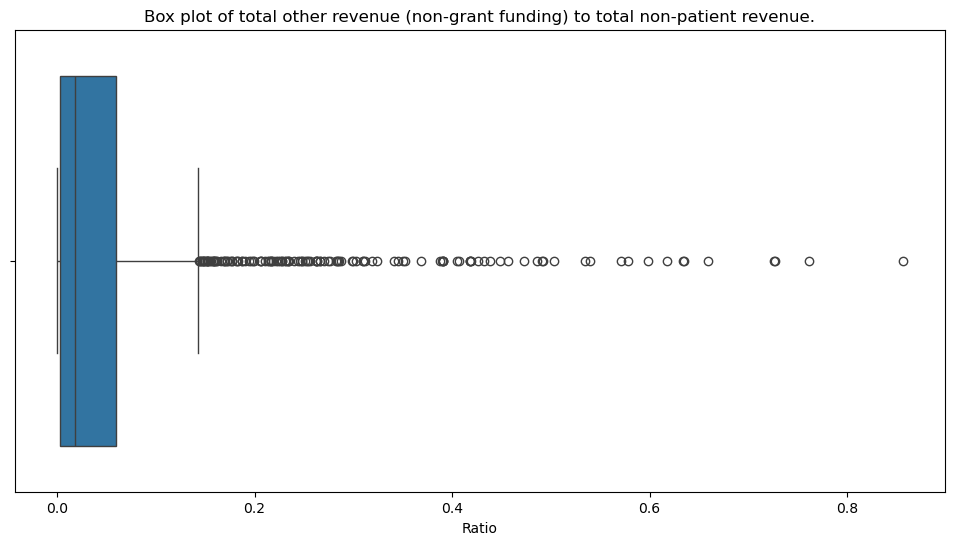

In [419]:
# calculate total other revenue  as a proportion of total revenue
health_centers['other_to_rev_ratio'] = health_centers['total_other_revenue'] / health_centers['total_revenue']

data_leakage_cols.append('other_to_rev_ratio')

fig, ax = plt.subplots(figsize=(12,6))

plt.title('Box plot of total other revenue (non-grant funding) to total non-patient revenue.')
sns.boxplot(x='other_to_rev_ratio', data=health_centers)

plt.xlabel('Ratio')

There are several outlier agencies where other revenue makes up the majority of their non-patient revenue, with some over 60% of their total revenue coming from sources other than grants. 

In [420]:
health_centers[['HealthCenterName', 'total_other_revenue', 'total_grant_funding', 'total_patients']].sort_values('total_other_revenue', ascending=False).head(20)

HealthCenterName  total_other_revenue  \
1120           ALTA MED HEALTH SERVICES CORPORATION            415573508   
23           EAST BOSTON NEIGHBORHOOD HEALTH CENTER             71967719   
8                            HARBOR HEALTH SERVICES             49539088   
329                  PIEDMONT HEALTH SERVICES, INC.             30738920   
293                           PHILADELPHIA, CITY OF             30576676   
962              DENVER HEALTH & HOSPITAL AUTHORITY             29785969   
33        BOSTON HEALTH CARE FOR THE HOMELESS, INC.             26609467   
135                 SUNSET PARK HEALTH COUNCIL, INC             22912139   
130              COMMUNITY HEALTHCARE NETWORK, INC.             21321355   
126                  HUDSON RIVER HEALTH CARE, INC.             19870205   
384                   CAROLINA HEALTH CENTERS, INC.             16845220   
0                       HOLYOKE HEALTH CENTER, INC.             14258919   
790              STIGLER HEALTH AND WELLNESS CENTER             11973859   
641                LAWNDALE CHRISTIAN HEALTH CENTER             10702594   
1257                SEA-MAR COMMUNITY HEALTH CENTER             10045410   
248   THREE LOWER COUNTIES COMMUNITY SERVICES, INC.              9902838   
547                BALDWIN FAMILY HEALTH CARE, INC.              9384678   
71                     RICHFORD HEALTH CENTER, INC.              9174828   
809          LEGACY COMMUNITY HEALTH SERVICES, INC.              9160662   
144                 THE INSTITUTE FOR FAMILY HEALTH              8814641   

      total_grant_funding  total_patients  
1120             55395011          245012  
23               29989791           81886  
8                 8614723           29114  
329              10562379           44655  
293               9478462           30555  
962              42027209          189225  
33               13624587           10174  
135              57990849          148873  
130              21277210           39938  
126              68907915          239574  
384               4873927           25770  
0                 6112612           19144  
790               9325731           30571  
641              13120900           53331  
1257             43827188          224180  
248               5460698           55318  
547               4703120           23217  
71                2420053           17781  
809              32943353          161254  
144              36193786          100697

**Does other revenue streams impact health center funding?**

Alta Med is a clear outlier, brining in nearly 6x more other revenue compared to the health center that brings in the 2nd most other revenue, East Boston Neighborhood Health Center. This could explain why their health center funding is so low compared to similarly other large health centers. 

I'll investigate this more closely by splitting up the health centers into two groups: 
1. high other revenue: health center's other revenue is beyond the 50th percentile
2. low other revenue: health center's other revenue is below the 50th percentile

Below I will investigate the two groups' distributions with boxplots. I will then perform a statistical test to analyze results.

**Null hypothesis:** There is no difference in health center funding between agencies with high and low other revenue sources. 

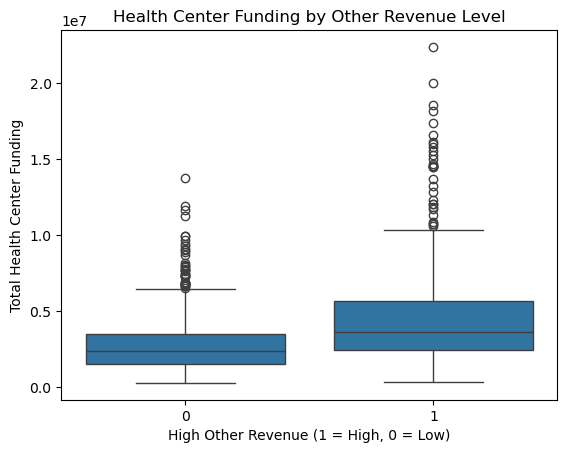

In [421]:
# Calculate the median or another quantile as the threshold
threshold = health_centers['total_other_revenue'].median()

# Create a binary variable based on this threshold
health_centers['high_other_revenue'] = (health_centers['total_other_revenue'] > threshold).astype(int)

sns.boxplot(x='high_other_revenue', y='total_hc_funding', data=health_centers)
plt.title('Health Center Funding by Other Revenue Level')
plt.xlabel('High Other Revenue (1 = High, 0 = Low)')
plt.ylabel('Total Health Center Funding')
plt.show()

Health centers with high other revenue seem to be more likely to have higher amounts of health center funding. This could be due to having larger operations.

In [422]:
model = ols('total_hc_funding ~ total_patients + C(high_other_revenue)', data=health_centers).fit()
ancova_table = sm.stats.anova_lm(model, typ=2)
ancova_table

sum_sq      df            F         PR(>F)
C(high_other_revenue)  8.225849e+13     1.0    23.815330   1.187590e-06
total_patients         4.453009e+15     1.0  1289.227128  2.559108e-198
Residual               4.624925e+15  1339.0          NaN            NaN

After performing an ANCOVA test, we can see that after controlling for total number of patients, health center's that are considered having high other revenue receive statistically more significant levels of total health center funding. Agencies in this category are likely able to demonstrate their ability to manage large amounts of government funding due to their operations and organizational structure. 

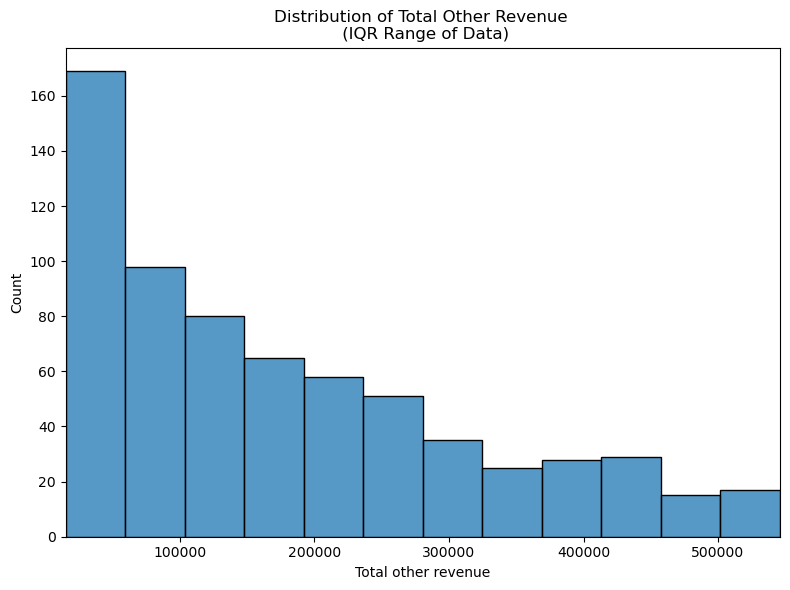

In [423]:
# distribution of total other revenue
other_rev = health_centers[(health_centers['total_other_revenue'] <= np.quantile(health_centers['total_other_revenue'], .75)) \
                           & (health_centers['total_other_revenue'] >= np.quantile(health_centers['total_other_revenue'], .25))]

fig, ax = plt.subplots(figsize=(8,6))

# Plotting low other revenue data
sns.histplot(other_rev['total_other_revenue'], ax=ax)
ax.set_xlim(left=other_rev['total_other_revenue'].min(), right=other_rev['total_other_revenue'].max())
ax.ticklabel_format(style='plain', axis='both')
ax.set_title('Distribution of Total Other Revenue \n (IQR Range of Data)')
ax.set_xlabel('Total other revenue')

plt.tight_layout()
plt.show()


In [424]:
health_centers[['total_other_revenue']].describe().apply(lambda x: x.apply('{0:.5f}'.format))

total_other_revenue
count          1342.00000
mean        1103317.91729
std        11790247.49148
min               0.00000
25%           15112.25000
50%          137021.50000
75%          546141.25000
max       415573508.00000

In [425]:
# Define bins
bin_edges = [0, 1, 100000, 500000, 1000000, 30000000, float('inf')]  # Use float('inf') for the upper edge

# labels
bin_labels = ['Zero', 'Less than 100K', '100K to 500K', '500K to 1M', '1M to 30M', 'Over 30M']

# create cat column
health_centers['other_revenue_category'] = pd.cut(health_centers['total_other_revenue'], bins=bin_edges, labels=bin_labels, right=False)

health_centers[['total_other_revenue', 'other_revenue_category']].head()

total_other_revenue other_revenue_category
0             14258919              1M to 30M
1                36578         Less than 100K
2               270649           100K to 500K
3              1753132              1M to 30M
4                    0                   Zero

In [426]:
health_centers['other_revenue_category'].value_counts()

other_revenue_category
100K to 500K      391
Less than 100K    388
Zero              210
1M to 30M         202
500K to 1M        146
Over 30M            5
Name: count, dtype: int64

<Axes: xlabel='other_revenue_category', ylabel='Count'>

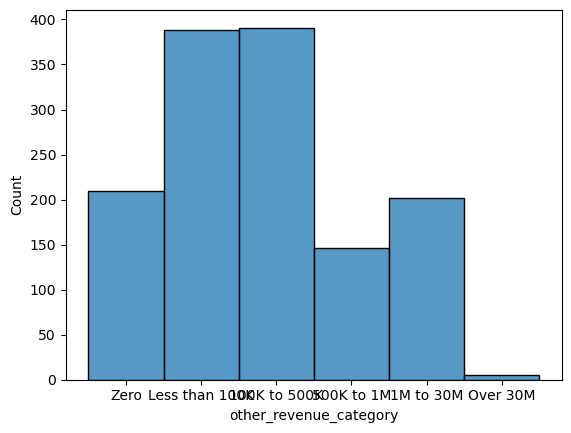

In [427]:
sns.histplot(health_centers['other_revenue_category'])

In [428]:
model = ols('total_hc_funding ~ total_patients + C(other_revenue_category)', data=health_centers).fit()
ancova_table = sm.stats.anova_lm(model, typ=2)
ancova_table

sum_sq      df            F         PR(>F)
C(other_revenue_category)  1.188204e+14     5.0     6.914240   2.203072e-06
total_patients             3.949096e+15     1.0  1149.003016  3.168564e-182
Residual                   4.588363e+15  1335.0          NaN            NaN

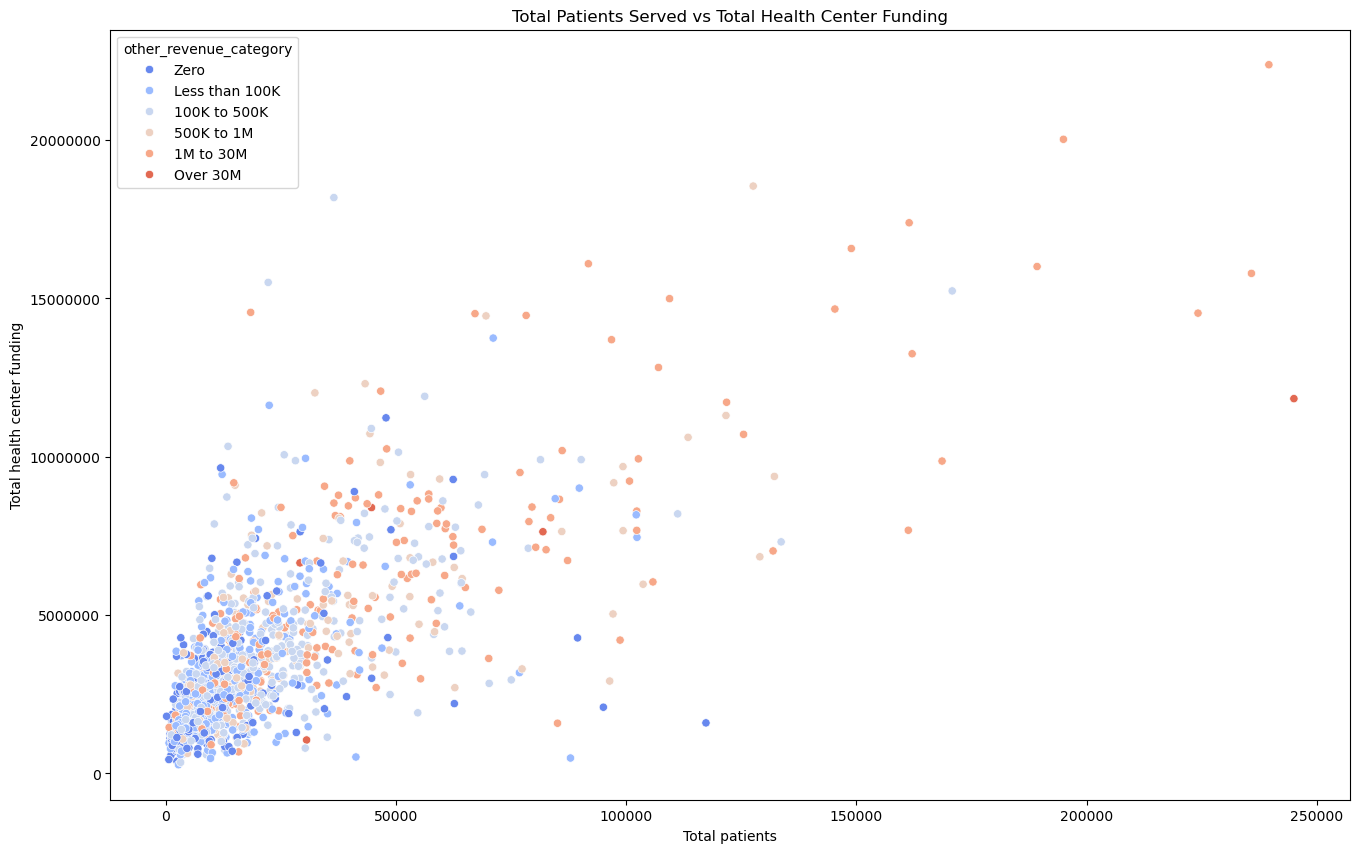

In [429]:
# scatter plot of health center funding vs total patients served
fix, ax = plt.subplots(figsize=(16,10))

sns.scatterplot(x='total_patients', y='total_hc_funding', data=health_centers, hue='other_revenue_category', palette='coolwarm')
plt.title('Total Patients Served vs Total Health Center Funding')
plt.xlabel('Total patients')
plt.ylabel('Total health center funding')
ax.ticklabel_format(style='plain', axis='both')

The larger health centers become, the more diversified their revenue streams appear. As some health centers increase in patient size, they seem to be more likely to have larger amounts of funding coming from other non-patient and non-grant revenue streams. However, we did see in the table earlier that this is not always the case. Some health centers that have massive amounts of total other revenue, like East Boston Neighborhood Health Center only serve a small number of patients, just over 80,000 in their case. 

In [430]:
health_centers = health_centers.drop(columns='high_other_revenue')

Let's look at patient revenue and operations.

In [431]:
funding = health_centers[['total_patients', 
                'total_hc_funding',
                'total_charges', 
                'total_collected', 
                'total_sfs']]

In [432]:
funding.describe().apply(lambda x: x.apply('{0:.2f}'.format))

total_patients total_hc_funding total_charges total_collected  \
count        1342.00          1342.00        730.00          730.00   
mean        22364.99       3670008.18   28845039.90     18631671.54   
std         27471.23       2741921.46   48450998.92     32262763.01   
min           154.00        275778.00       7314.00            0.00   
25%          6978.00       1804645.00    6604409.50      4034753.50   
50%         13635.50       2858228.50   15226385.00      9531353.00   
75%         26232.25       4605680.25   31986191.75     21451209.50   
max        245012.00      22382349.00  672511973.00    525686359.00   

         total_sfs  
count       730.00  
mean    2460500.04  
std     5452232.72  
min           0.00  
25%      245935.25  
50%      834191.00  
75%     2280879.75  
max    64698474.00

I'm interested to look at the entity or entities that have 0 sliding fee scale discounts. Health centers are mandated to offer services on a sliding fee scale by law, so it is curious why there would be an entity that says 0 sfs discounts provided. 

In [433]:
no_sfs = health_centers[health_centers['total_sfs'] == 0][['HealthCenterName', 'total_hc_funding']]
print(no_sfs.shape)
no_sfs

(7, 2)


HealthCenterName  total_hc_funding
527   RECOVERY CONSULTANTS OF ATLANTA, INCORPORATED           1246352
727        LUTHERAN SOCIAL SERVICES OF CENTRAL OHIO           1369045
968             COLORADO COALITION FOR THE HOMELESS           9178083
998        COMMUNITY ACTION OF LARAMIE COUNTY, INC.            438893
1128             MINISTRY OF HEALTH AND ENVIRONMENT            653252
1255                           MANILLAQ ASSOCIATION           2944978
1340      CHUUK STATE DEPARTMENT OF HEALTH SERVICES            792000

There are 7 organizations that did not report any sliding fee scale discount charges. I wanted to see if maybe this was because they are brand new entities. I looked up the first three organizations and they do say they offer sliding fee scales at their organizations. I am not sure why 0 would be lsited for these entities. 

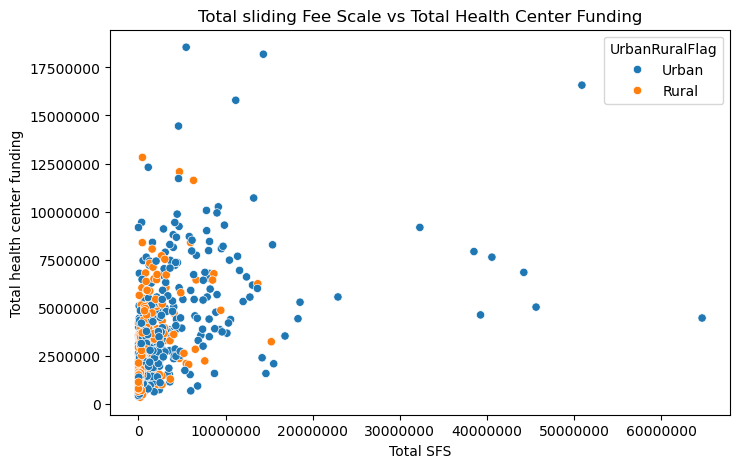

In [434]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=health_centers, x='total_sfs', y='total_hc_funding', hue='UrbanRuralFlag', ax=ax)
plt.title('Total sliding Fee Scale vs Total Health Center Funding')
plt.xlabel('Total SFS')
plt.ylabel('Total health center funding')
ax.ticklabel_format(style='plain', axis='both')

Urban entities seem to provide more sliding fee scale services compared to rural entities, even though some rural entities receive more health center funding compared to the urban entities. 

Let's look at charges vs collections

In [435]:
health_centers['collections_charges_ratio'] = health_centers['total_collected'] / health_centers['total_charges']

In [436]:
health_centers[['HealthCenterName', 'collections_charges_ratio']].sort_values('collections_charges_ratio', ascending=False).head(25)

HealthCenterName  \
1334                     N. A. T. I. V. E. PROJECT, THE   
1252                                  WHITE BIRD CLINIC   
1195                               GREENVILLE RANCHERIA   
1272           CLACKAMAS COUNTY HEALTH CENTERS DIVISION   
1040          COUNTY OF SACRAMENTO DOH & HUMAN SERVICES   
1320                                        LANE COUNTY   
1306                                     MOSAIC MEDICAL   
1266             VIRGINIA GARCIA MEMORIAL HEALTH CENTER   
1271                                        HEALTHPOINT   
1089                          KARUK TRIBE OF CALIFORNIA   
308                                   CITY OF FREDERICK   
1018         COMMUNITY HEALTH CARE CENTER, INCORPORATED   
556            FAMILY HEALTH CENTER OF MARSHFIELD, INC.   
1091                                   COUNTY OF SOLANO   
1274           LINCOLN COUNTY HEALTH AND HUMAN SERVICES   
237               KEYSTONE RURAL HEALTH CONSORTIA, INC.   
1313                                         OUTSIDE IN   
1176                          ACHIEVABLE FOUNDATION THE   
1297                       COWLITZ FAMILY HEALTH CENTER   
1127                            NEIGHBORHOOD HEALTHCARE   
1044                                  SANTA CRUZ COUNTY   
634   VALLEY PROFESSIONALS COMMUNITY HEALTH CENTER, ...   
929                              ALL CARE HEALTH CENTER   
1264                              YAKUTAT TLINGIT TRIBE   
1294             SEATTLE-KING COUNTY PUBLIC HEALTH DEPT   

      collections_charges_ratio  
1334                   2.862926  
1252                   2.635001  
1195                   2.075171  
1272                   1.681848  
1040                   1.623509  
1320                   1.607073  
1306                   1.548311  
1266                   1.510768  
1271                   1.486528  
1089                   1.485061  
308                    1.332890  
1018                   1.307309  
556                    1.290922  
1091                   1.277720  
1274                   1.268251  
237                    1.252436  
1313                   1.228966  
1176                   1.226378  
1297                   1.188100  
1127                   1.172606  
1044                   1.171129  
634                    1.169752  
929                    1.157401  
1264                   1.137016  
1294                   1.129052

I'm not sure how to interpret the results of the collections to charges ratio. Health centers should not be collecting more per visit than what is charged. The overage may be due to collecting on charges made in a previous year. I will drop this new column due to insufficient understanding of the data.

In [437]:
health_centers.drop(columns=['collections_charges_ratio', 'total_collected','total_charges'], inplace=True)

## Social Determinants of Health 

I want to look how and if social determinant of health and funding is correlated. Health centers are supposed to increase access to care for vulnerable populations. Do entities that serve more vulnerable populations receive more funding? Which SDOH impact funding the most?

**Financial Insecurity**

First I will take a look at total number of people served at or below 100% Federal Poverty Level. Financial barriers to care is one of the most pressing challenges to address in access to care. I would think this heavily influences total health center funding. 

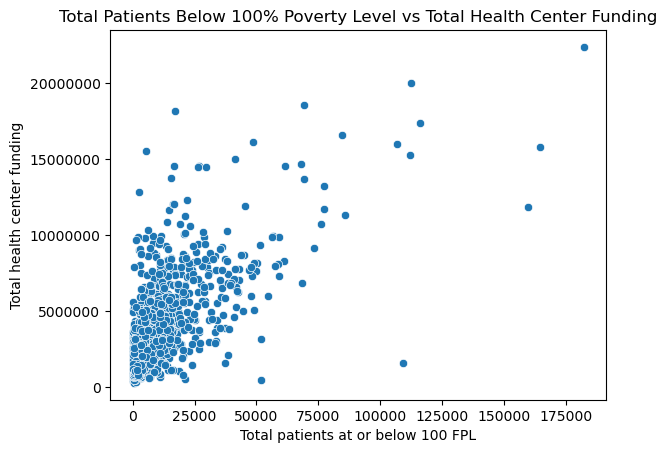

In [438]:
fix, ax = plt.subplots()

sns.scatterplot(x='fpl_100_below', y='total_hc_funding', data=health_centers)
plt.title('Total Patients Below 100% Poverty Level vs Total Health Center Funding')
plt.xlabel('Total patients at or below 100 FPL')
plt.ylabel('Total health center funding')
ax.ticklabel_format(style='plain', axis='both')

In [439]:
health_centers['fpl_100_below'].describe()

count      1342.000000
mean       9896.867362
std       15290.344228
min           0.000000
25%        2101.250000
50%        5043.500000
75%       11426.750000
max      182300.000000
Name: fpl_100_below, dtype: float64

It apeears that the entity that receives the most health center funding also serves the greatest number of patients at or below 100% federally poverty level. They serve over 175,000 patiets with high financial barriers to care. 

Several other outlier entities also receive a lot of funding for high number of financially insecure individuals. However, there are also quite a few entities that receive high amount of funding and do not serve that many financial insecure patients by comparison.

I am going to use Plotly so I can make this scatter plot more interactive to see which intities they are. 

In [440]:
df = health_centers
fig = px.scatter(df, x='fpl_100_below', y='total_hc_funding', hover_data='HealthCenterName', 
                 size='total_patients', 
                 title = "Total patients at or below 100% FPL vs Health center funding", 
                 width=800, height=600)
fig.show()

We see that Hudson is the entity that provides the most in terms of care to people at or below 100% federal poverty level, serving 182.3K patients in 2022. 

**Racial and Ethnic Minorities**

Race and ethnicity are two other factors that largely influence individuals' access to care. This is largely due to historical and systemic racism in the United States. Although we will not be examining how this influences access to care at an individual level, I want to see if it does impact the funding levels for organizations. Specifically, do organizations that serve higher proportions of racial and ethnic diversity receive more funding?

We are going to need to aggregate the race columns into a new racial diversity column which will exclude white, hispanic any race and unreported. We are exclusing hispanic any race since this is an ethnicity. Also, patients represented as hispanic could also be counted as a race, so we don't want to double count them. 

Because some health centers serve a lot more patients that others, I will also want to calculate these as proportions for analysis. 

In [441]:
# identify columns to aggregate
race_cols_agg = ['asian', 'native_hawaiian', 'pac_isl', 'black', 'am_ind']

# sum up these results
health_centers['diverse_patients_sum'] = health_centers[race_cols_agg].sum(axis=1)

# calculate the proportion of total patients that are diverse
health_centers['diverse_race_proportion'] = health_centers['diverse_patients_sum'] / health_centers['total_patients']
health_centers['hispanic_proportion'] = health_centers['hispanic_any_race'] / health_centers['total_patients']

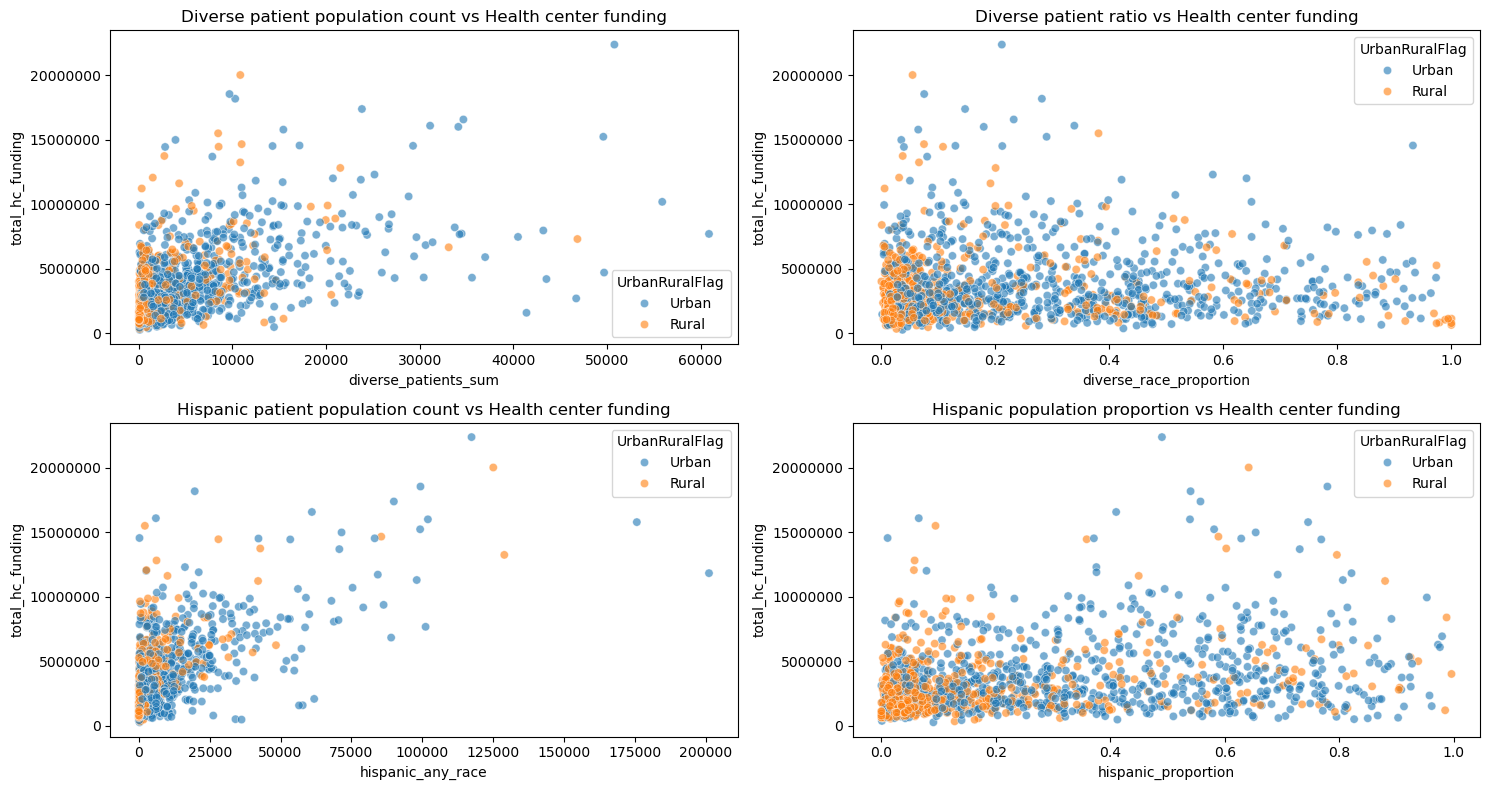

In [442]:
fit, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

ax[0,0] = sns.scatterplot(x='diverse_patients_sum', y='total_hc_funding', data=health_centers, ax=ax[0,0], hue='UrbanRuralFlag', alpha=0.6)
ax[0,0].set_title('Diverse patient population count vs Health center funding')
ax[0,0].ticklabel_format(style='plain', axis='both')


ax[0,1] = sns.scatterplot(x='diverse_race_proportion', y='total_hc_funding', data=health_centers, ax=ax[0,1], hue='UrbanRuralFlag', alpha=0.6)
ax[0,1].set_title('Diverse patient ratio vs Health center funding')
ax[0,1].ticklabel_format(style='plain', axis='both')

ax[1,0] = sns.scatterplot(x='hispanic_any_race', y='total_hc_funding', data=health_centers, ax=ax[1,0], hue='UrbanRuralFlag', alpha=0.6)
ax[1,0].set_title('Hispanic patient population count vs Health center funding')
ax[1,0].ticklabel_format(style='plain', axis='both')

ax[1,1] = sns.scatterplot(x='hispanic_proportion', y='total_hc_funding', data=health_centers, ax=ax[1,1], hue='UrbanRuralFlag', alpha=0.6)
ax[1,1].set_title('Hispanic population proportion vs Health center funding')
ax[1,1].ticklabel_format(style='plain', axis='both')

plt.tight_layout()
plt.show()


There does not appear to be a strong relationship between either proportion of racially or ethnically diverse patients and total health center funding. However, there appears to be a positive correlation between the number of racially or ethnically diverse patients served and total health center funding. This shows that the number of patients served is more important than the proportion who are racially or ethnically diverse. 

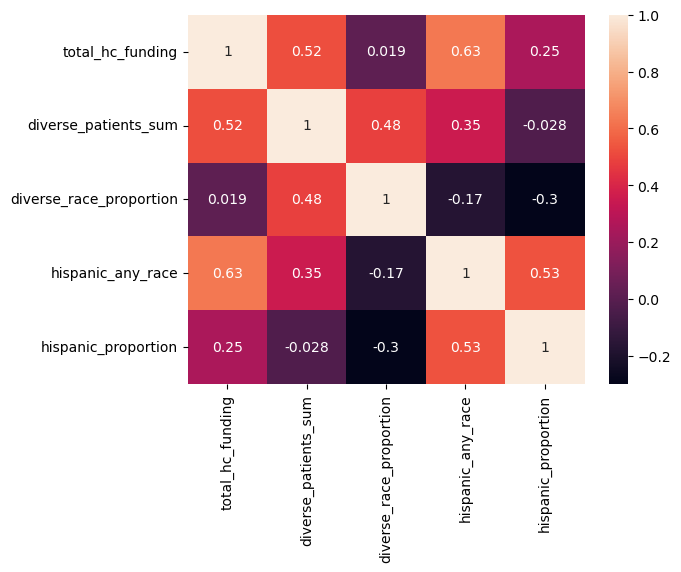

In [443]:
# Calculate correlation matrix
correlation_matrix = health_centers[['total_hc_funding', 'diverse_patients_sum', 'diverse_race_proportion', 'hispanic_any_race', 'hispanic_proportion']].corr()

# Display the correlation matrix
sns.heatmap(correlation_matrix, annot=True);


The correlation matrix confirms my ealier observations that the number of racially diverse patients and the number of hispanic patients are positively correlated with health center funding. Given that absolute numbers show a stronger relationship with funding, it may be more impactful to focus on increasing the total number of diverse and Hispanic patients served, particularly if funding allocation is a priority.

While proportions don’t show a strong direct relationship with funding, they are essential for understanding equity and representation within health services. They might not directly influence funding amount but are critical for policy-making, resource allocation, and community engagement strategies. The health center program aims to fund health care in areas with high need. 

It is interesting to see the negative correlation between hispanic proportion vs racially diverse populations. This could suggest that health centers are more focused on specific racial and ethnic groups. 

I'll drop the individual race columns. I will likely drop the proportion columns as well, but I want to look at a few more things first regarding the impact of proportions on health center funding. 

In [444]:
# drop columns
health_centers.drop(columns=(race_cols_agg), inplace=True)
health_centers.drop(columns=['white', 'unreported'], inplace=True)

Okay, I want to get a brief overview of any relationship the other social determinants of health may have to total health center funding. I will quickly visualize them as scatter plots. Several of these features may make more sense to aggregate, such as the various insurance groupings. 

In [445]:
health_centers.head()

BHCMISID GrantNumber                          HealthCenterName  \
0   010030  H80CS00803               HOLYOKE HEALTH CENTER, INC.   
1   010040  H80CS00443          MAINE MOBILE HEALTH PROGRAM INC.   
2   010060  H80CS00741  FAIR HAVEN COMMUNITY HEALTH CLINIC, INC.   
3   010070  H80CS00312     CORNELL SCOTT HILL HEALTH CORPORATION   
4   010120  H80CS00001        CITY OF SPRINGFIELD, MASSACHUSETTS   

  HealthCenterCity HealthCenterState  FundingCHC  FundingMHC  FundingHO  \
0          Holyoke                MA        True       False      False   
1          Augusta                ME       False        True      False   
2        New Haven                CT        True       False      False   
3        New Haven                CT        True       False       True   
4      Springfield                MA       False       False       True   

   FundingPH UrbanRuralFlag  mhc_amount  chc_amount  ho_amount  ph_amount  \
0      False          Urban           0     5721128          0          0   
1      False          Rural     1758567           0          0          0   
2      False          Urban           0     4569124          0          0   
3       True          Urban           0     4553563    1041417     565694   
4      False          Urban           0           0    1842241          0   

   total_hc_funding  bphc_total  total_other_revenue  total_revenue  \
0           5721128     7584461             14258919       28330029   
1           1758567     2258650                36578        2320228   
2           4569124     6571573               270649        9064640   
3           6160674     9587880              1753132       17483690   
4           1842241     2042241                    0        2050671   

   total_male  total_female  hispanic_any_race  total_patients  lep_patients  \
0        8821         10323              12631           19144          8371   
1         609           241                471             850           654   
2       14150         17768              19204           31918         12686   
3       21230         31204              19860           52434         12197   
4        1350           705                857            2055           461   

   fpl_100_below  fpl_101_to_150  fpl_151_to_200  uninsured_0_17  \
0           2706             184             103             104   
1            768              68              11              35   
2          13138            3958            1685            1329   
3          22703            3842            1816             809   
4           1291              63              29               0   

   uninsured_18_up  medicaid_0_17  medicaid_18_up  medicare_18_up  \
0              609           4882            8638            3320   
1              734             24              36               4   
2             3138          16495            5818            1686   
3             4629           6433           26163            3210   
4              331             36            1321             295   

   public_insurance_0_17  public_insurance_18_up  private_insurance_0_17  \
0                     10                      13                     166   
1                      0                       0                       8   
2                      0                       0                    1543   
3                      0                       0                     882   
4                      0                       0                       0   

   private_insurance_18_up  total_0_17  total_18_up  migrant_patients  \
0                     1410        5157        13987                45   
1                       13          64          786               769   
2                     1908       19368        12550                 5   
3                    10306        8126        44308                16   
4                       72          36         2019                85   

   homeless_patients  school_based_patients  vetera

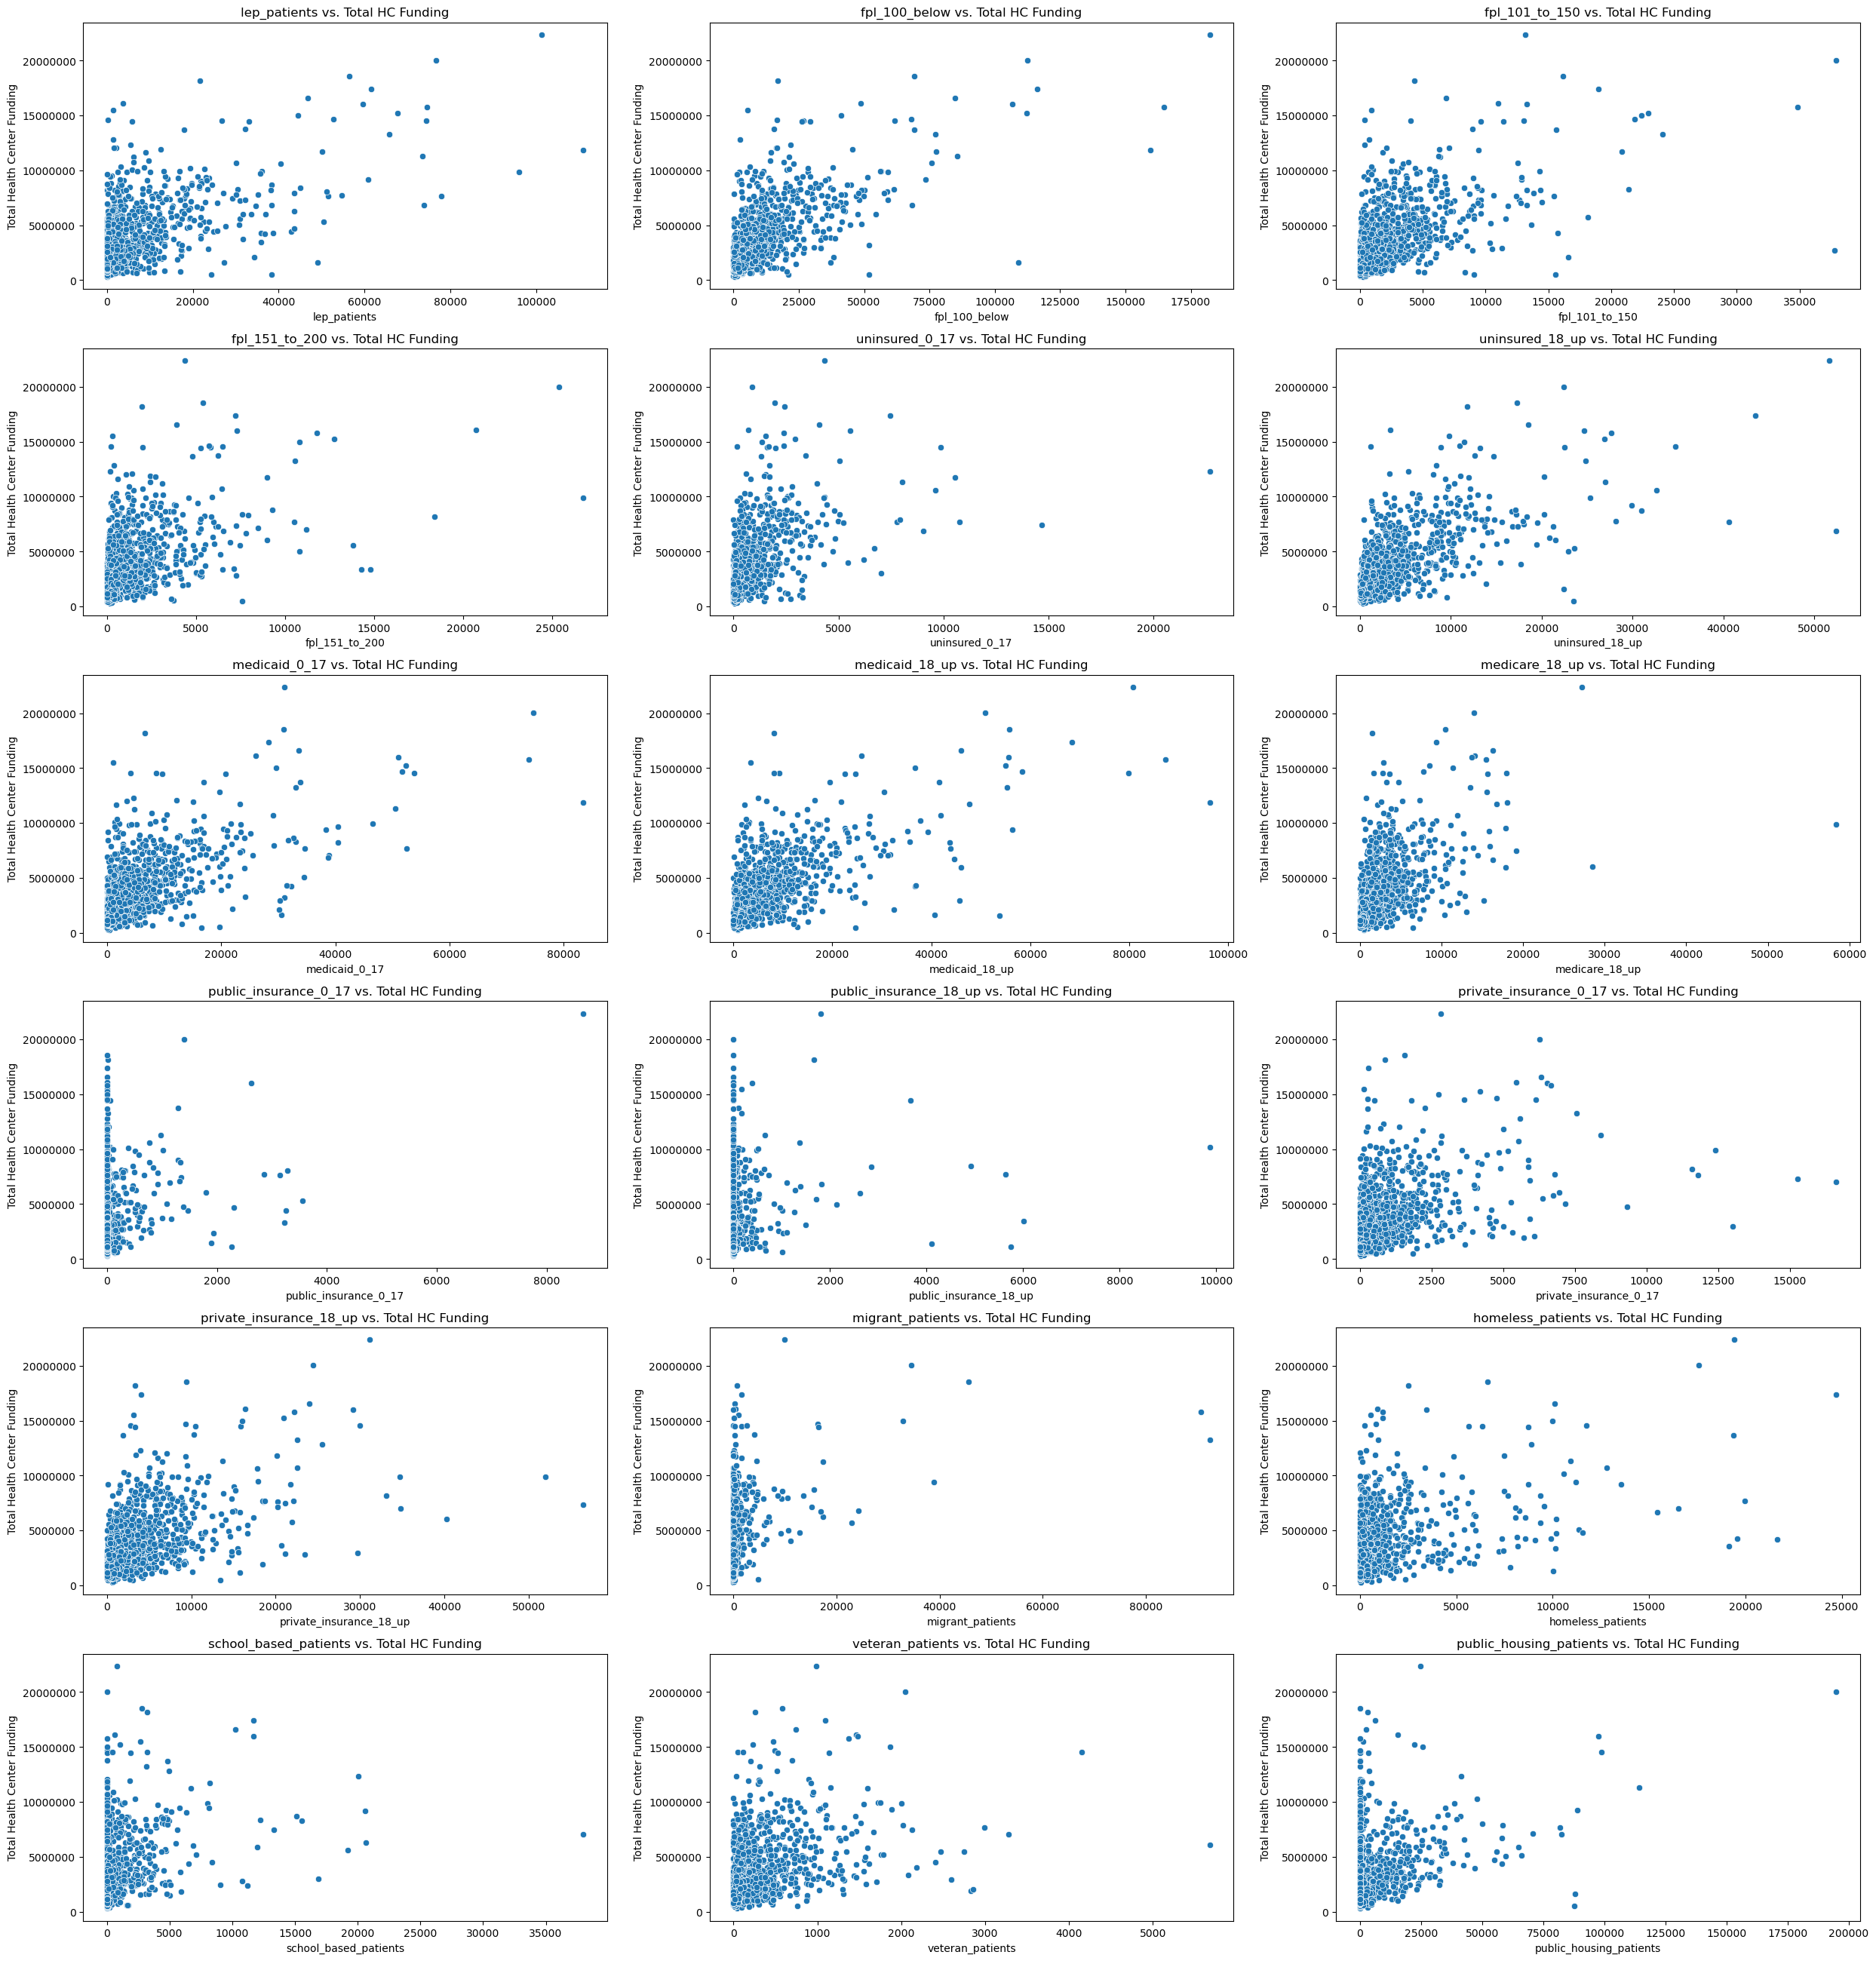

In [446]:
# Define the list of x variables you want to plot against 'total_hc_funding'
sdoh_vars = [
    'lep_patients', 'fpl_100_below', 'fpl_101_to_150', 'fpl_151_to_200',
    'uninsured_0_17', 'uninsured_18_up', 'medicaid_0_17', 'medicaid_18_up',
    'medicare_18_up', 'public_insurance_0_17', 'public_insurance_18_up',
    'private_insurance_0_17', 'private_insurance_18_up',
    'migrant_patients', 'homeless_patients', 'school_based_patients',
    'veteran_patients', 'public_housing_patients'
]

# create subplots
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(25, 30))  # Adjust the size as necessary
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop over the variables and create a scatter plot for each
for i, var in enumerate(sdoh_vars):
    sns.scatterplot(ax=axes[i], data=health_centers, x=var, y='total_hc_funding')
    axes[i].set_title(f'{var} vs. Total HC Funding')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Total Health Center Funding')
    axes[i].ticklabel_format(style='plain', axis='both')

for ax in axes[len(sdoh_vars):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [447]:
# Calculate correlation matrix
correlation_matrix = health_centers[['total_hc_funding'] + sdoh_vars].corr()

In [448]:
# Extract correlations for 'total_hc_funding' against all other variables
funding_correlations = correlation_matrix['total_hc_funding'].drop('total_hc_funding')
funding_correlations.sort_values()

public_insurance_18_up     0.152980
public_insurance_0_17      0.255181
school_based_patients      0.298931
public_housing_patients    0.316256
migrant_patients           0.357924
veteran_patients           0.377339
private_insurance_0_17     0.422626
homeless_patients          0.429777
fpl_151_to_200             0.496552
uninsured_0_17             0.504004
private_insurance_18_up    0.528933
medicare_18_up             0.532512
fpl_101_to_150             0.578885
lep_patients               0.595988
medicaid_0_17              0.632499
medicaid_18_up             0.649934
uninsured_18_up            0.656609
fpl_100_below              0.666679
Name: total_hc_funding, dtype: float64

Although several of these features appear to be strongly correlated with funding, I believe it may be due to total patients served rather than these features themselves, similar to the observations earlier with race and ethnicity proportions. I will aggregate across age groups and then calculate proportions for each of these categories instead.

In [449]:
# Set display option to show more columns
pd.set_option('display.max_columns', None)

# Print the column names
print(df.columns)


Index(['BHCMISID', 'GrantNumber', 'HealthCenterName', 'HealthCenterCity',
       'HealthCenterState', 'FundingCHC', 'FundingMHC', 'FundingHO',
       'FundingPH', 'UrbanRuralFlag', 'mhc_amount', 'chc_amount', 'ho_amount',
       'ph_amount', 'total_hc_funding', 'bphc_total', 'total_other_revenue',
       'total_revenue', 'total_male', 'total_female', 'hispanic_any_race',
       'total_patients', 'lep_patients', 'fpl_100_below', 'fpl_101_to_150',
       'fpl_151_to_200', 'uninsured_0_17', 'uninsured_18_up', 'medicaid_0_17',
       'medicaid_18_up', 'medicare_18_up', 'public_insurance_0_17',
       'public_insurance_18_up', 'private_insurance_0_17',
       'private_insurance_18_up', 'total_0_17', 'total_18_up',
       'migrant_patients', 'homeless_patients', 'school_based_patients',
       'veteran_patients', 'public_housing_patients', 'total_costs_medical',
       'total_costs_dental', 'total_costs_mh', 'total_costs_enabling',
       'total_costs_quality', 'total_cost_care', 'total_sfs'

In [450]:
# create aggregations
health_centers['low_income'] = health_centers[['fpl_100_below', 'fpl_101_to_150', 'fpl_151_to_200']].sum(axis=1)
health_centers['uninsured'] = health_centers['uninsured_0_17'] + health_centers['uninsured_18_up']
health_centers['medicaid'] = health_centers['medicaid_0_17'] + health_centers['medicaid_18_up']
health_centers['public_insurance'] = health_centers['public_insurance_0_17'] + health_centers['public_insurance_18_up']
health_centers['private_insurance'] = health_centers['private_insurance_0_17'] + health_centers['private_insurance_18_up']

# poverty ratio
health_centers['poverty_ratio'] = health_centers['fpl_100_below'] / health_centers['total_patients']

In [451]:
ratio_columns = ['total_0_17', 'total_18_up', 'lep_patients', 'fpl_100_below', 'low_income', 'uninsured', 'medicaid', 'medicare_18_up', 'public_insurance', 
                 'private_insurance', 'migrant_patients', 'homeless_patients', 'school_based_patients', 'veteran_patients', 'public_housing_patients']

for col in ratio_columns:
    health_centers[col+'_ratio'] = health_centers[col] / health_centers['total_patients']

In [452]:
# drop redundant features
sdoh_aggs_to_drop = ['fpl_100_below', 
                'fpl_101_to_150', 
                'fpl_151_to_200', 
                'uninsured_0_17', 
                'uninsured_18_up', 
                'medicaid_0_17', 
                'medicaid_18_up', 
                'public_insurance_0_17', 
                'public_insurance_18_up', 
                'private_insurance_0_17', 
                'private_insurance_18_up',
                'total_0_17', 
                'total_18_up',
                'total_male', 
                'total_female']

health_centers = health_centers.drop(columns=sdoh_aggs_to_drop)

In [453]:
sdoh_props = ['total_0_17_ratio', 'total_18_up_ratio', 'lep_patients_ratio', 'poverty_ratio', 'low_income_ratio', 'uninsured_ratio', 'medicaid_ratio', 
              'medicare_18_up_ratio', 'public_insurance_ratio', 'private_insurance_ratio','migrant_patients_ratio', 'homeless_patients_ratio', 
              'school_based_patients_ratio', 'veteran_patients_ratio', 'public_housing_patients_ratio']

correlation_matrix = health_centers[['total_hc_funding'] + sdoh_props].corr()

funding_correlations_v2 = correlation_matrix['total_hc_funding'].drop('total_hc_funding')
funding_correlations_v2.sort_values()

total_18_up_ratio               -0.172484
veteran_patients_ratio          -0.165378
private_insurance_ratio         -0.159732
medicare_18_up_ratio            -0.143927
homeless_patients_ratio         -0.005390
public_insurance_ratio           0.004526
public_housing_patients_ratio    0.041438
school_based_patients_ratio      0.042145
uninsured_ratio                  0.050845
low_income_ratio                 0.077426
poverty_ratio                    0.116768
medicaid_ratio                   0.123642
migrant_patients_ratio           0.152484
total_0_17_ratio                 0.172518
lep_patients_ratio               0.182549
Name: total_hc_funding, dtype: float64

<Axes: >

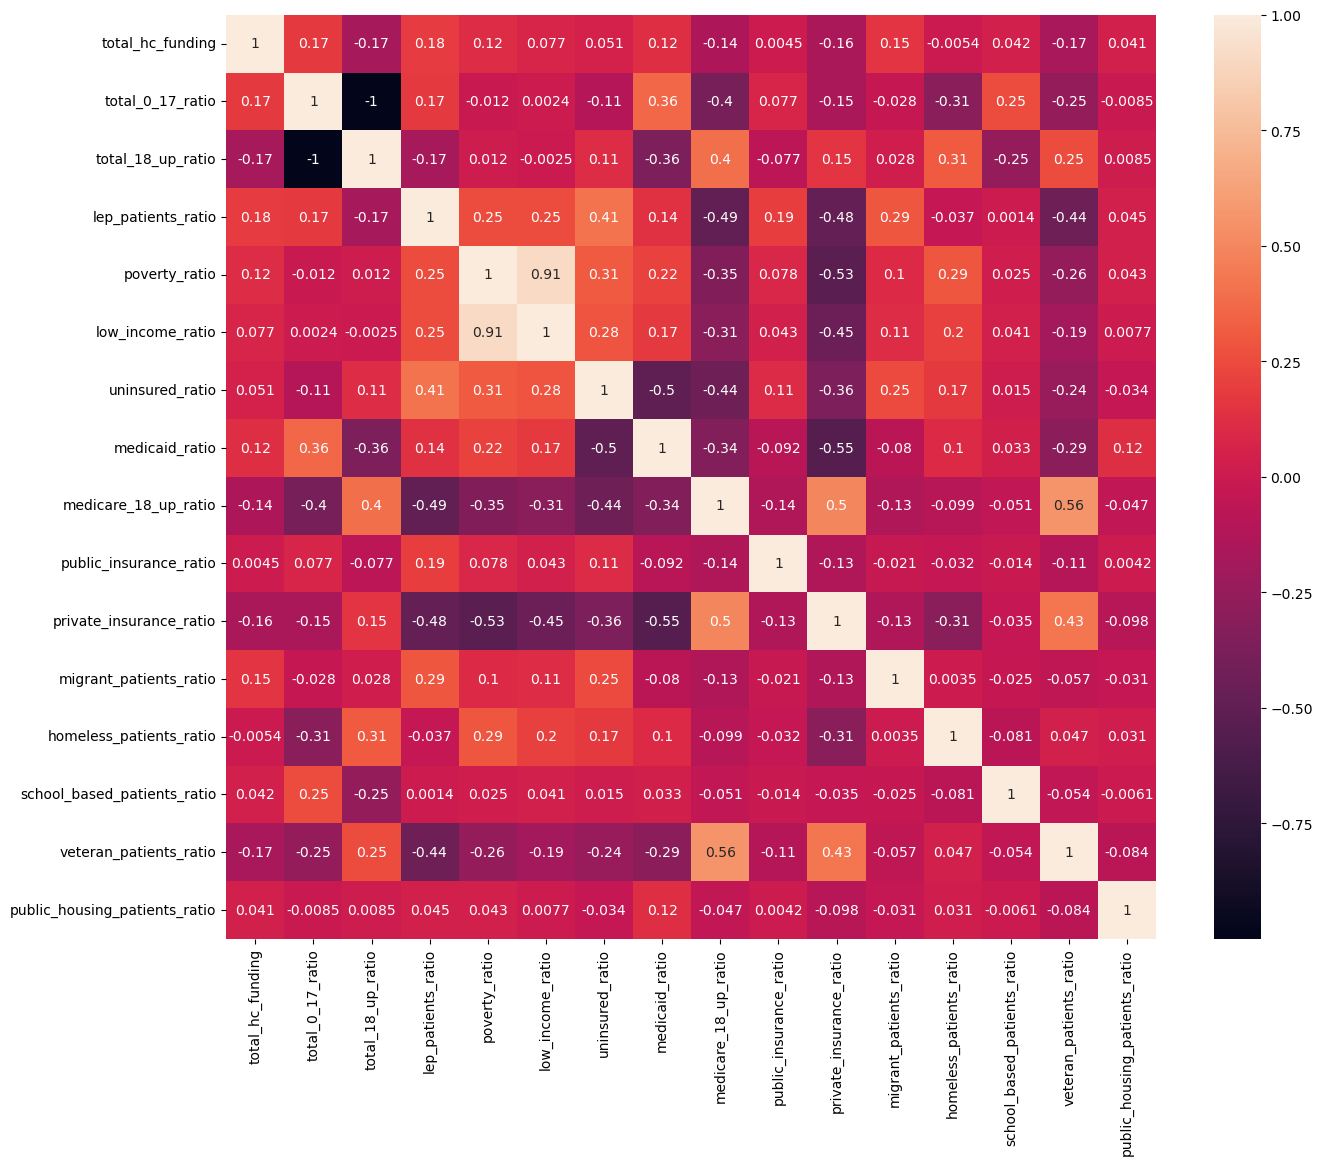

In [454]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(correlation_matrix, annot=True)

There is some negative correlation between private health insurance and health center funding, as well as Medicare insurance and health center funding, these were not very strong correlations, -0.16 and -0.14 respectively.

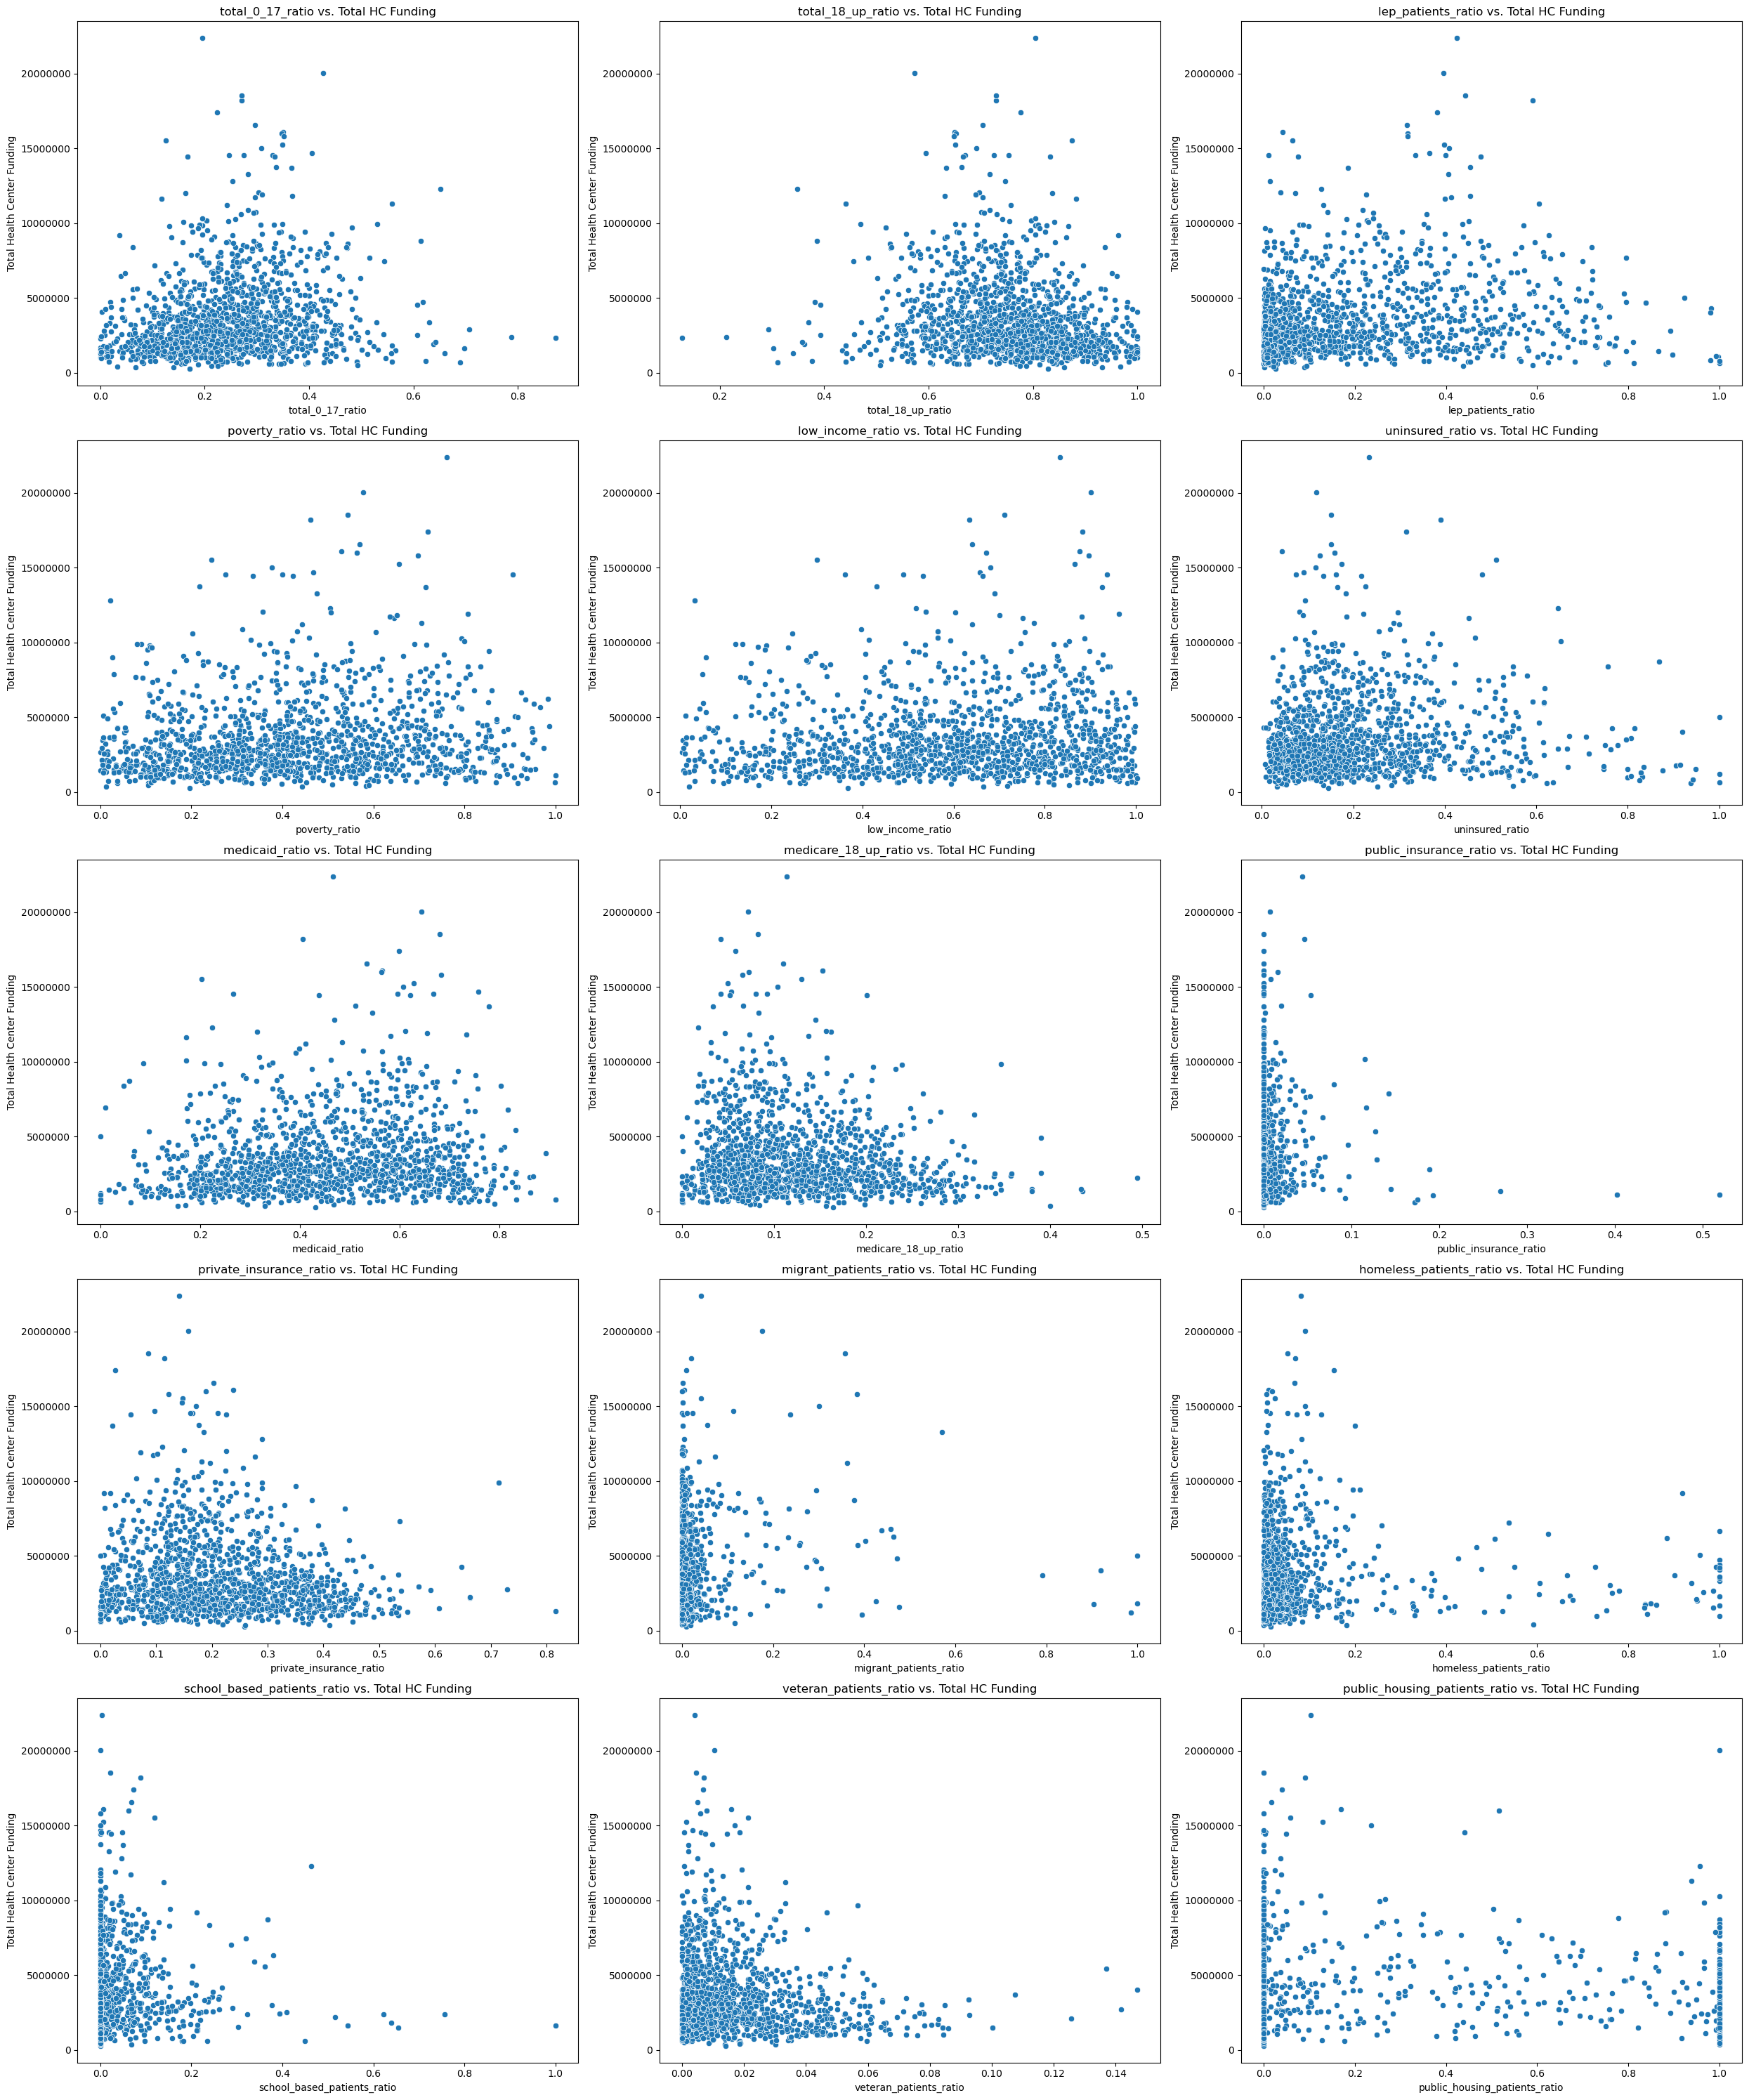

In [455]:
# create subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(25, 30))
axes = axes.flatten()

# Loop over the variables and create a scatter plot for each
for i, var in enumerate(sdoh_props):
    sns.scatterplot(ax=axes[i], data=health_centers, x=var, y='total_hc_funding')
    axes[i].set_title(f'{var} vs. Total HC Funding')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Total Health Center Funding')
    axes[i].ticklabel_format(style='plain', axis='both')  # Turn off scientific notation
    
for ax in axes[len(sdoh_props):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

We see some very minor correlations between patients' social determinants of health proportions and total health center funding. I am surprised to see that there is virtually no correlation between proportion of uninsured patients and total funding received. Later I will conduct statistical tests to see how proportions of patients affect funding. Specifically, I want to test whether there are certain thresholds that result in more or less funding. 

In [456]:
health_centers[['diverse_race_proportion', 'hispanic_proportion']].describe().T

count      mean       std       min       25%  \
diverse_race_proportion  1342.0  0.245955  0.244399  0.001001  0.044771   
hispanic_proportion      1342.0  0.273645  0.257951  0.000000  0.051733   

                              50%       75%       max  
diverse_race_proportion  0.154015  0.387297  1.000000  
hispanic_proportion      0.183895  0.451601  0.995829

<Axes: ylabel='Count'>

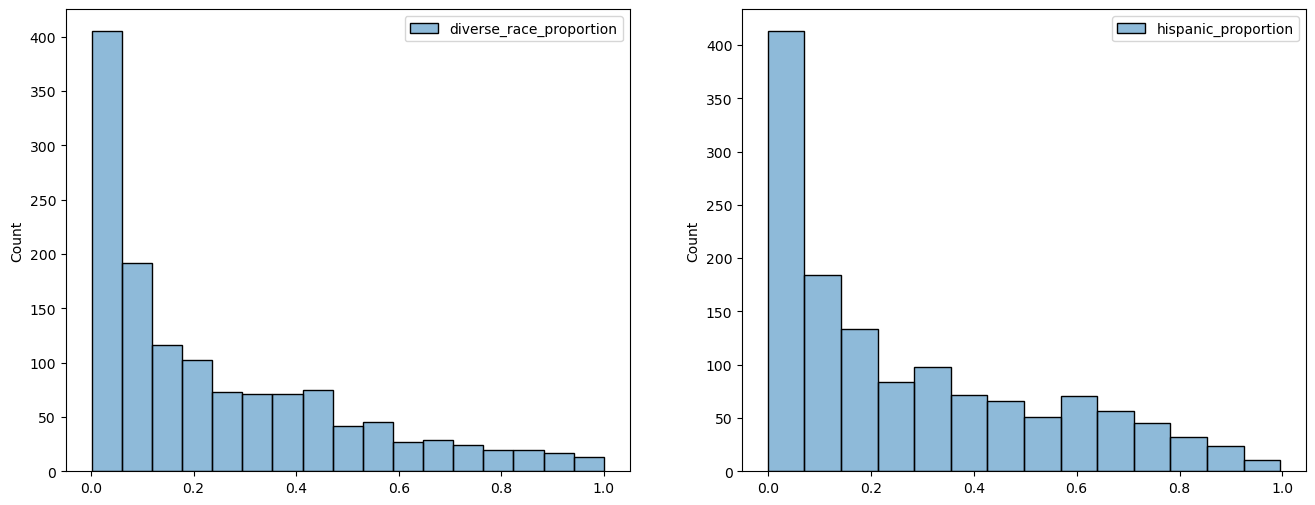

In [457]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns. histplot(health_centers[['diverse_race_proportion']], ax=ax[0])
sns.histplot(health_centers[['hispanic_proportion']], ax=ax[1])

In [458]:
health_centers[sdoh_props].describe().T.sort_values('75%', ascending=False)

count      mean       std       min       25%  \
total_18_up_ratio              1342.0  0.750824  0.120882  0.127803  0.676056   
low_income_ratio               1342.0  0.589172  0.251444  0.004390  0.414131   
medicaid_ratio                 1342.0  0.449923  0.181836  0.000000  0.313223   
poverty_ratio                  1342.0  0.427336  0.231341  0.000000  0.253902   
total_0_17_ratio               1342.0  0.249174  0.120887  0.000000  0.164730   
lep_patients_ratio             1342.0  0.194019  0.209455  0.000000  0.022766   
private_insurance_ratio        1342.0  0.214986  0.125878  0.000000  0.122591   
uninsured_ratio                1342.0  0.207078  0.168237  0.004402  0.088900   
medicare_18_up_ratio           1342.0  0.121679  0.076783  0.000000  0.062870   
public_housing_patients_ratio  1342.0  0.193921  0.356905  0.000000  0.000000   
homeless_patients_ratio        1342.0  0.064532  0.162500  0.000000  0.003906   
veteran_patients_ratio         1342.0  0.017066  0.018196  0.000000  0.004627   
school_based_patients_ratio    1342.0  0.029925  0.076008  0.000000  0.000000   
migrant_patients_ratio         1342.0  0.023041  0.083494  0.000000  0.000371   
public_insurance_ratio         1342.0  0.005902  0.025454  0.000000  0.000000   

                                    50%       75%       max  
total_18_up_ratio              0.755562  0.835270  1.000000  
low_income_ratio               0.611993  0.798789  1.003235  
medicaid_ratio                 0.447821  0.594082  0.912991  
poverty_ratio                  0.411949  0.592941  1.000000  
total_0_17_ratio               0.244438  0.323944  0.872197  
lep_patients_ratio             0.119271  0.313838  1.000000  
private_insurance_ratio        0.196553  0.295933  0.815911  
uninsured_ratio                0.161810  0.275875  1.000000  
medicare_18_up_ratio           0.103807  0.170294  0.494910  
public_housing_patients_ratio  0.000000  0.158375  1.000000  
homeless_patients_ratio        0.013974  0.046041  1.000000  
veteran_patients_ratio         0.010857  0.023315  0.146988  
school_based_patients_ratio    0.000000  0.021876  1.000000  
migrant_patients_ratio         0.003059  0.010807  1.000000  
public_insurance_ratio         0.000000  0.001105  0.518634

Most health centers do not provide services to patients on other types of public insurance (outside of Medicare and Medicaid).
 

In [459]:
sdoh_to_drop_2 = ['hispanic_any_race',
                  'diverse_patients_sum',
                  'lep_patients', 
                  'low_income', 
                  'uninsured', 
                  'medicaid', 
                  'medicare_18_up',
                  'public_insurance', 
                  'private_insurance',
                  'migrant_patients', 
                  'homeless_patients', 
                  'school_based_patients', 
                  'veteran_patients', 
                  'public_housing_patients']

sdoh_to_drop_2.extend([                    
                     'migrant_patients_ratio', 
                     'homeless_patients_ratio', 
                     'school_based_patients_ratio', 
                     'veteran_patients_ratio',   
                     'public_housing_patients_ratio'])

#health_centers = health_centers.drop(columns=sdoh_to_drop_2)


## Summary of Analysis on Diversity and SDOH

What I found most interesting is that the volume of patients belonging to racial and ethnic mintorities, as well as the volume of patients with one or more social determinant of health appears to be more important for health center funding funding than the ratio of total patients served in each of these categories. I was under the assumption that the proportions would be more of a factor if health centers serve patients who are not considered high need. We will see if some of thes features have mroe importance than other later on during modeling. 

## Health Center Operations

In [460]:
# subset operations data and total funding and patients

ops = health_centers[['total_hc_funding', 'total_patients', 'total_costs_medical', 'total_costs_dental', 'total_costs_mh',
       'total_costs_enabling', 'total_costs_quality', 'total_cost_care',
       'medical_clinic_visits', 'medical_virtual_visits', 'medical_patients',
       'dental_clinic_visits', 'dental_virtual_visits', 'dental_patients',
       'mh_clinic_visits', 'mh_virtual_visits', 'mh_patients',
       'enabling_clinic_visits', 'enabling_virtual_visits',
       'enabling_patients', 'total_clinic_visits', 'total_virtual_visits',
       'ZipCode_Count', 'SiteCity_Count', 'SiteState_Count',
       'Admin_Service_Delivery_Sites_Count', 'Service_Delivery_Sites_Count',
       'TotalWeeklyHoursOfOperation']]

In [461]:
missing = ops.isna().sum().reset_index()
missing.rename(columns={0:'count_missing'}, inplace=True)
missing['perc_missing'] = ((missing['count_missing'] / len(ops)) * 100).round(2)
missing

index  count_missing  perc_missing
0                     total_hc_funding              0          0.00
1                       total_patients              0          0.00
2                  total_costs_medical            610         45.45
3                   total_costs_dental            610         45.45
4                       total_costs_mh            610         45.45
5                 total_costs_enabling            610         45.45
6                  total_costs_quality            610         45.45
7                      total_cost_care            610         45.45
8                medical_clinic_visits            561         41.80
9               medical_virtual_visits            561         41.80
10                    medical_patients            561         41.80
11                dental_clinic_visits            561         41.80
12               dental_virtual_visits            561         41.80
13                     dental_patients            561         41.80
14                    mh_clinic_visits            561         41.80
15                   mh_virtual_visits            561         41.80
16                         mh_patients            561         41.80
17              enabling_clinic_visits            561         41.80
18             enabling_virtual_visits            561         41.80
19                   enabling_patients            561         41.80
20                 total_clinic_visits            561         41.80
21                total_virtual_visits            561         41.80
22                       ZipCode_Count              0          0.00
23                      SiteCity_Count              0          0.00
24                     SiteState_Count              0          0.00
25  Admin_Service_Delivery_Sites_Count              0          0.00
26        Service_Delivery_Sites_Count              0          0.00
27         TotalWeeklyHoursOfOperation              0          0.00

The operations dataframe is missing a lot of data and it is missing not at random. During pre-processing, I want to try imputing values using MICE impuation. HOwever, I first want to look at these variables for which I do have data to see if I will keep them all or make any changes. 

In [462]:
health_centers['SiteState_Count'].value_counts()

SiteState_Count
1    1300
2      36
3       6
Name: count, dtype: int64

In [463]:
ops_correlation_matrix = ops.corr()
ops_correlation_matrix_simple = ops_correlation_matrix['total_hc_funding'].drop('total_hc_funding')
ops_correlation_matrix_simple.sort_values(ascending=False)


total_patients                        0.730138
total_costs_medical                   0.660748
total_clinic_visits                   0.655571
medical_patients                      0.647498
total_cost_care                       0.631972
medical_clinic_visits                 0.624303
total_costs_dental                    0.607720
dental_patients                       0.604578
TotalWeeklyHoursOfOperation           0.603722
dental_clinic_visits                  0.597622
Service_Delivery_Sites_Count          0.582044
total_costs_enabling                  0.566226
SiteCity_Count                        0.506061
ZipCode_Count                         0.482782
total_costs_quality                   0.445830
medical_virtual_visits                0.442605
total_virtual_visits                  0.439256
mh_patients                           0.390889
enabling_patients                     0.386259
total_costs_mh                        0.354200
enabling_clinic_visits                0.306801
mh_virtual_vi

In [464]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the DataFrame for intercept
X = add_constant(ops.drop(columns='total_hc_funding').dropna())

# Calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# Display VIF
print(vif.round(2).sort_values('VIF Factor', ascending=False))


    VIF Factor                            features
21      537.38                total_virtual_visits
20      362.59                 total_clinic_visits
8       290.09               medical_clinic_visits
1       211.40                      total_patients
10      207.18                    medical_patients
9       200.42              medical_virtual_visits
15      120.01                   mh_virtual_visits
11       62.76                dental_clinic_visits
0        44.82                               const
13       43.21                     dental_patients
2        25.75                 total_costs_medical
7        20.52                     total_cost_care
18       17.81             enabling_virtual_visits
27       15.79         TotalWeeklyHoursOfOperation
4        15.32                      total_costs_mh
14       14.04                    mh_clinic_visits
26       12.13        Service_Delivery_Sites_Count
3        11.14                  total_costs_dental
16        9.21                 

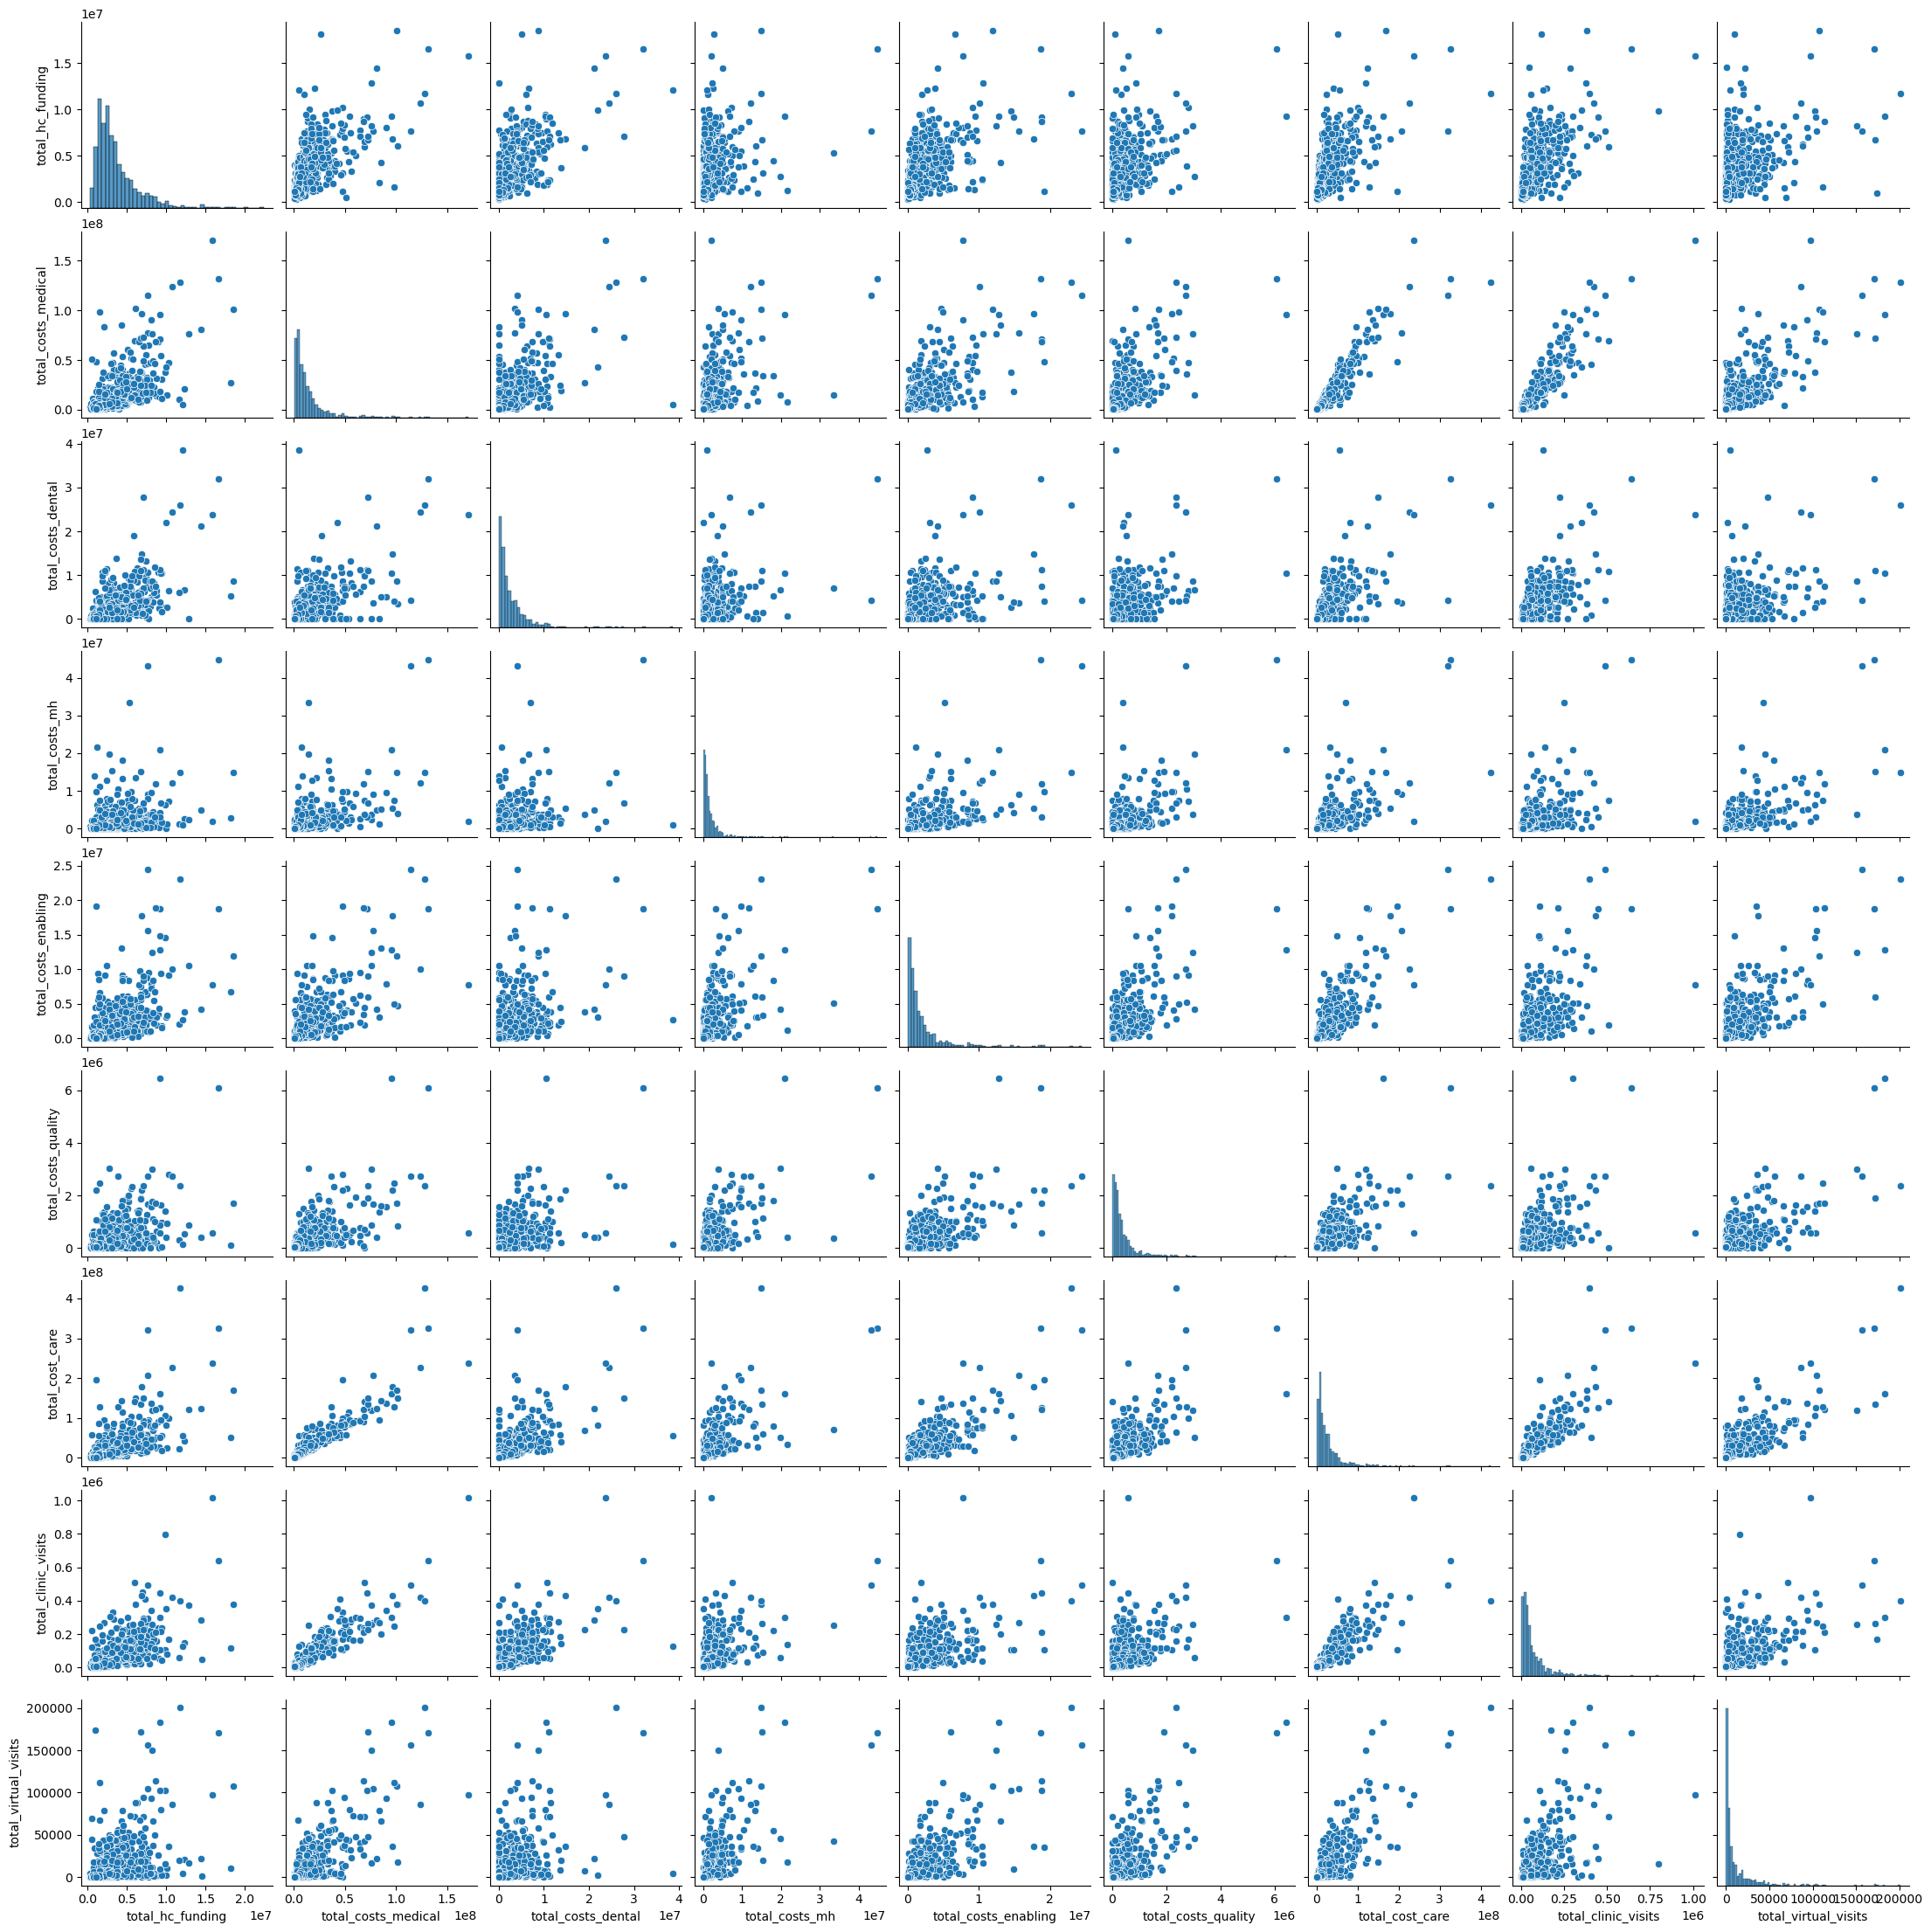

In [465]:
sns.pairplot(ops[['total_hc_funding', 'total_costs_medical', 'total_costs_dental', 'total_costs_mh',
       'total_costs_enabling', 'total_costs_quality', 'total_cost_care', 'total_clinic_visits', 'total_virtual_visits']])

## Health Center Operations Analysis
In general, we can see that total funding increases across the board with increased medical, dental, mental health, quality, and enabling service costs as well as the various types of clinical visits. Instead of keeping all of these columns, I am going to keep just the total columns for costs of care, visits, and virtual visits as they demonstrate similar trends to the more detailed columns when plotted agains total_hc_funding. These columns are also most strongly correlated with total health center funding. Additionally, there is likely some colinearity in these data because as there are increased visits, there are increased costs of care and vice versa. 

The count of administrative sites does not seem to be particularly meaningful for any relationships with overall operations. I am going to add this count to the service delivery sites column to provide a new value. I am not simply removing this column because some smaller operations may have their administrative site in the same place as their clinical services site, and it may be their only operation service site. 

The count of states entities are operating in also does not seem to provide much in terms of relationship with funding or other columns. I will remove this for modeling. 

In [466]:
#combine enabling services visit types
health_centers['total_enabling_visits'] = health_centers['enabling_clinic_visits'] + health_centers['enabling_virtual_visits']

# combine total visits (clinic and virtual)
health_centers['total_visits'] = health_centers['total_clinic_visits'] + health_centers['total_virtual_visits']

# combine admin site count and service delivery site count
health_centers['total_sites'] = health_centers['Service_Delivery_Sites_Count'] + health_centers['Admin_Service_Delivery_Sites_Count']

ops_to_drop = [
    'total_costs_medical',
    'total_costs_dental',
    'total_costs_mh',
    'total_costs_enabling',
    'total_costs_quality',
    'medical_clinic_visits',
    'medical_virtual_visits',
    'medical_patients',
    'dental_clinic_visits',
    'dental_virtual_visits',
    'dental_patients',
    'mh_clinic_visits',
    'mh_virtual_visits',
    'mh_patients',
    'enabling_clinic_visits',
    'enabling_virtual_visits',
    'total_clinic_visits',
    'total_virtual_visits',
    'Service_Delivery_Sites_Count', 
    'Admin_Service_Delivery_Sites_Count'
]

health_centers = health_centers.drop(columns=ops_to_drop)

In [467]:
# add health center funding break out columns to be removed to prevent data leakage
data_leakage_cols.extend(['mhc_amount', 'chc_amount', 'ho_amount', 'ph_amount'])
data_leakage_cols

['bphc_total',
 'total_revenue',
 'hc_grant_revenue_ratio',
 'other_to_rev_ratio',
 'mhc_amount',
 'chc_amount',
 'ho_amount',
 'ph_amount']

In [468]:
# define columns to drop before
cols_to_drop = ['GrantNumber', 'HealthCenterCity']

In [469]:
# create new dataframe
df = health_centers.drop(columns=cols_to_drop)

Text(0.5, 0, 'Funding per patient ($)')

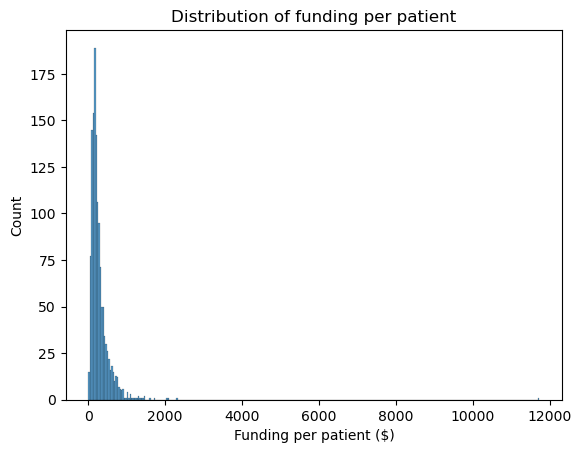

In [470]:
df['funding_per_patient'] = df['total_hc_funding'] / df['total_patients']

data_leakage_cols.append('funding_per_patient')

fig, ax = plt.subplots()
sns.histplot(df['funding_per_patient'], ax=ax)
plt.title('Distribution of funding per patient')
plt.xlabel('Funding per patient ($)')

In [471]:
df['funding_per_patient'].describe()

count     1342.000000
mean       291.614254
std        391.721783
min          5.547653
25%        140.481550
50%        213.381970
75%        344.111102
max      11727.675325
Name: funding_per_patient, dtype: float64

Interestingly there are huge outliers in this graph, with some entities receiving significantly more funding per patient than most others. There are also others that have extremely low funding per patient values.  Let's take a closer look at the data. 

This is intersting because earlier the charts demonstrate how the volume of patients served is strongly correlated with total funding. This suggests that some smaller entities receive more funding proportionally despite not serving as many patients as large entities. I am going to investigate some of the difference between these entities by grouping them and seeing if they differ in any of the newly calculated columns.

In [472]:
# define bin edges
edges = df['funding_per_patient'].quantile([0, 0.25, 0.50, 0.75, 0.90, 1]).values

# define labels for the bins
labels = ['0-25%', '25-50%', '50-75%', '75-90%', '90-100%']

# create the categorical groups
df['funding_per_patient_group'] = pd.cut(df['funding_per_patient'], bins=edges, labels=labels, include_lowest=True)

# verify the distribution among the categories
print(df['funding_per_patient_group'].value_counts())

funding_per_patient_group
0-25%      336
25-50%     335
50-75%     335
75-90%     201
90-100%    135
Name: count, dtype: int64


In [473]:
df.pivot_table(values=['total_sfs', 'total_visits', 
                       'ZipCode_Count', 'SiteCity_Count', 'total_sites', 'TotalWeeklyHoursOfOperation', 
                       'total_grant_funding', 'total_patients'], 
               index='funding_per_patient_group', aggfunc='mean').apply(lambda x: x.apply('{0:.2f}'.format))

SiteCity_Count TotalWeeklyHoursOfOperation  \
funding_per_patient_group                                              
0-25%                               6.71                      737.93   
25-50%                              4.93                      434.59   
50-75%                              3.80                      295.64   
75-90%                              2.95                      261.77   
90-100%                             3.22                      254.88   

                          ZipCode_Count total_grant_funding total_patients  \
funding_per_patient_group                                                    
0-25%                            115.48          9101239.99       48008.61   
25-50%                            72.32          5512887.88       22047.39   
50-75%                            57.76          3408381.51       13151.48   
75-90%                            40.63          2646052.65        7693.96   
90-100%                           34.69          2043592.50        4035.73   

                            total_sfs total_sites total_visits  
funding_per_patient_group                                       
0-25%                      4660273.17       17.87    177269.04  
25-50%                     2535435.88       11.82     84893.06  
50-75%                     1666789.59        7.87     48798.28  
75-90%                     1300383.36        7.05     29429.07  
90-100%                     672843.29        5.99     16400.27

In [474]:
data_leakage_cols.append('funding_per_patient_group')

In [475]:
df = df.drop(columns=data_leakage_cols)

In [476]:
df['ops_confidential'] = df['total_visits'].isnull().astype('int')
df['fin_confidential'] = df['total_cost_care'].isnull().astype('int')
df[['ops_confidential', 'fin_confidential']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ops_confidential  1342 non-null   int64
 1   fin_confidential  1342 non-null   int64
dtypes: int64(2)
memory usage: 21.1 KB


These entities seem to also be smaller operations on average, as is show by the table above. 

## Statistical Tests

One of the assumptions I would like to test is whether certain proportions of underserved patient categories affect funding levels. Earlier we saw that the volumes of patients served broken down by category (race, insurance status, financial status, etc.) were highly correlated with total health center funding. 

In [477]:
def logit_test_quantiles(df, col, target_col):


    quantiles = [0, 0.25, 0.5, 0.75, 1.0]
    
    # Calculate quantile-based bin edges
    edges = df[col].quantile(quantiles).tolist()
    
    # Ensure the minimum and maximum values are included
    edges[0] = df[col].min()  # Replace the first element with the actual minimum
    edges[-1] = df[col].max()  # Replace the last element with the actual maximum

    df[col + '_bins'] = pd.cut(df[col], bins=edges, labels=['Q1', 'Q2', 'Q3', 'Q4'])

    X = pd.get_dummies(df[col + '_bins'], drop_first=True, dtype=int)
    y = (df[target_col] > df[target_col].median()).astype(int)
    
    try:
        log_reg = sm.Logit(y, sm.add_constant(X)).fit()
        print(log_reg.summary())

    except Exception:
        print(f"Error fitting logit model for {col}: {Exception}")

In [478]:
def logit_test_binary(df, col, target_col):
    threshold = df[col].quantile(0.50)
    df[col + '_above_median'] = (df[col] > threshold).astype(int)
    y = (df[target_col] > df[target_col].median()).astype(int)

    X = df[[col + '_above_median']]
    X = sm.add_constant(X)  # Adding a constant for the intercept

    try:
        logit_model = sm.Logit(y, X)
        result = logit_model.fit()
        print(result.summary())

    except Exception:
        print(f"Error fitting logit model for {col}: {Exception}")

In [479]:
health_centers.columns

Index(['BHCMISID', 'GrantNumber', 'HealthCenterName', 'HealthCenterCity',
       'HealthCenterState', 'FundingCHC', 'FundingMHC', 'FundingHO',
       'FundingPH', 'UrbanRuralFlag', 'mhc_amount', 'chc_amount', 'ho_amount',
       'ph_amount', 'total_hc_funding', 'bphc_total', 'total_other_revenue',
       'total_revenue', 'hispanic_any_race', 'total_patients', 'lep_patients',
       'medicare_18_up', 'migrant_patients', 'homeless_patients',
       'school_based_patients', 'veteran_patients', 'public_housing_patients',
       'total_cost_care', 'total_sfs', 'enabling_patients', 'ZipCode_Count',
       'SiteCity_Count', 'SiteState_Count', 'TotalWeeklyHoursOfOperation',
       'hc_grant_revenue_ratio', 'total_grant_funding', 'grants_to_rev_ratio',
       'other_to_rev_ratio', 'other_revenue_category', 'diverse_patients_sum',
       'diverse_race_proportion', 'hispanic_proportion', 'low_income',
       'uninsured', 'medicaid', 'public_insurance', 'private_insurance',
       'poverty_ratio',

In [480]:
logit_test_quantiles(health_centers, 'ZipCode_Count', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.597525
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                  0.1380
Time:                        16:50:43   Log-Likelihood:                -801.88
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 2.385e-55
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3143      0.133     -9.901      0.000      -1.574      -1.054
Q2             0.8912      0.

In [481]:
logit_test_quantiles(health_centers, 'total_patients', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.488584
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                  0.2951
Time:                        16:50:43   Log-Likelihood:                -655.68
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                1.117e-118
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1841      0.181    -12.074      0.000      -2.539      -1.830
Q2             1.6009      0.

In [482]:
logit_test_quantiles(health_centers, 'diverse_race_proportion', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.689080
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                0.005867
Time:                        16:50:43   Log-Likelihood:                -924.75
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                   0.01219
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2998      0.110     -2.718      0.007      -0.516      -0.084
Q2             0.3416      0.

In [483]:
logit_test_quantiles(health_centers, 'hispanic_proportion', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.672596
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.02965
Time:                        16:50:43   Log-Likelihood:                -902.62
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 6.349e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5235      0.113     -4.639      0.000      -0.745      -0.302
Q2             0.3620      0.

In [484]:
logit_test_quantiles(health_centers, 'low_income_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.689604
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                0.005112
Time:                        16:50:43   Log-Likelihood:                -925.45
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                   0.02322
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2877      0.110     -2.610      0.009      -0.504      -0.072
Q2             0.3414      0.

In [485]:
logit_test_quantiles(health_centers, 'poverty_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.684595
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.01234
Time:                        16:50:43   Log-Likelihood:                -918.73
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 4.131e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3980      0.111     -3.577      0.000      -0.616      -0.180
Q2             0.3204      0.

In [486]:
logit_test_quantiles(health_centers, 'medicaid_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.682458
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.01542
Time:                        16:50:43   Log-Likelihood:                -915.86
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 2.602e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4729      0.112     -4.216      0.000      -0.693      -0.253
Q2             0.5267      0.

In [487]:
logit_test_quantiles(health_centers, 'lep_patients_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.674147
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.02741
Time:                        16:50:43   Log-Likelihood:                -904.70
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 4.898e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5620      0.113     -4.954      0.000      -0.784      -0.340
Q2             0.4004      0.

In [488]:
logit_test_quantiles(health_centers, 'private_insurance_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.682863
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.01484
Time:                        16:50:43   Log-Likelihood:                -916.40
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 4.400e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1911      0.110      1.743      0.081      -0.024       0.406
Q2             0.0187      0.

In [489]:
logit_test_quantiles(health_centers, 'uninsured_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.686040
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.01025
Time:                        16:50:43   Log-Likelihood:                -920.67
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 0.0002638
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3980      0.111     -3.577      0.000      -0.616      -0.180
Q2             0.4159      0.

In [490]:
logit_test_quantiles(health_centers, 'medicare_18_up_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.686508
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1338
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                0.009578
Time:                        16:50:43   Log-Likelihood:                -921.29
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 0.0004792
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0715      0.109      0.655      0.513      -0.143       0.285
Q2             0.2110      0.

In [491]:
logit_test_binary(health_centers, 'homeless_patients_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.686200
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.01002
Time:                        16:50:43   Log-Likelihood:                -920.88
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 1.574e-05
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -0.2366      0.0

In [492]:
logit_test_binary(health_centers, 'veteran_patients_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.688448
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                0.006780
Time:                        16:50:43   Log-Likelihood:                -923.90
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 0.0003831
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.1944      0.078 

In [493]:
logit_test_binary(health_centers, 'public_housing_patients_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.670195
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.03311
Time:                        16:50:43   Log-Likelihood:                -899.40
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 4.199e-15
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       

In [494]:
logit_test_binary(health_centers, 'migrant_patients_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.692213
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                0.001348
Time:                        16:50:43   Log-Likelihood:                -928.95
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                    0.1133
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.0865      0.077 

In [495]:
logit_test_binary(health_centers, 'school_based_patients_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.665847
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                 0.03939
Time:                        16:50:43   Log-Likelihood:                -893.57
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                 1.128e-17
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.4

In [496]:
logit_test_binary(health_centers, 'public_insurance_ratio', 'total_hc_funding')

Optimization terminated successfully.
         Current function value: 0.692420
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:       total_hc_funding   No. Observations:                 1342
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Sep 2024   Pseudo R-squ.:                0.001049
Time:                        16:50:43   Log-Likelihood:                -929.23
converged:                       True   LL-Null:                       -930.20
Covariance Type:            nonrobust   LLR p-value:                    0.1623
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.0477      0.064 

## Concluding Thoughts

Overall the size of an entity's operation, measured by the number of service provided, number of patients, hours of operations, number of sites, number of zipcodes, number of cities, and total revenue streams (including patient and non-patient revenue), are positively correlated with their total health center grant funding. However, we saw earlier that there are outliers where there are a number organizations that serve smaller patient populations but receive large grants. These entities receive much more funding per patient than several of the largest operations, and some of the main features associated with these difference include higher uninsured patient ratios, diverse patient ratios, homeless patient ratios, and smaller operational capacities. 

New entities may want to prioritize funding per patient versus total overall health center grant funding. 

Although I didn't observe very strong correlations between the ratio of patients in certain demographic groups and total health center funding, I want to conduct some statistical tests to determine if various demographic factors or demographic factors combined contribute to funding levels, as I observed after splitting up entities based on their funding per patient. Similarly, I want to see if there is a statistically significant difference in entities based on special populations funding, being an urban vs rural provider, and amount of other non-patient revenue. 

In [497]:
df.to_csv(DATA_PATH +'modeling/data_new_features.csv', index=False)